### Imports

In [30]:
# General Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report

from utils import *

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# We want to predict Claim Injury Type

In [32]:
# Neeed to create utils.py, model.py and a way to store/load the trained models.

# To-Do List: EDA, Preprocessing, and Data Preparation

**Our target is Claim Injury Type**

## 1. Exploratory Data Analysis (EDA)
   - **1.1 Data Overview**
     - Inspect the dataset structure.
     - Check for missing values (NAs) in each column. (There are missing values in the target, what's the % of NAs for each column)
     - Analyze basic statistics for numerical features (mean, median, min, max, etc.). ( .info and .describe)
     - Investigate categorical features (value counts, unique values).
     - Identify anomalies and duplicates in the data. (Age being NA is different from being 0 and Zip Code can be either a str or an int)

   - **1.2 Correlations and Relationships**
     - Compute correlation matrix for numerical features. (Can be done after dealing with categorical variables)
     - Identify and analyze feature relationships with target class using plots (e.g., boxplots, violin plots, histograms).

   - **1.3 Target Variable Analysis**
     - We should do it before and after preprocessing (maybe?).
     - Analyze class distribution of the target variable (severely unbalanced).
     - Identify potential patterns between features and classes with less data.
     - Discuss and visualize how imbalance could affect model performance.

## 2. Data Preprocessing
   - **2.1 Handling Missing Data and Anomalies**
     - Treat missing values (e.g., imputation, deletion). (We drop the ones that are in the target)
     - Convert variables that have contextual NAs into dummies (C-2 Date and C-3 Date could be NAs because at the time were yet to happen so they can become C-2 Ocurred, 0 or 1)

   - **2.2 Feature Engineering**
     - **2.2.1 Date Features**
       - Convert date features (e.g., `Accident Date`, `C-2 Date`) into meaningful time variables (e.g., days from a reference date).
       - For now we are calling the new feature related to date `feature` Days, we should decide a better name.
     - **2.2.2 Age**
       - Convert birth year into age in years.
       - We could group by Age and search for patterns.

   - **2.3 Categorical Feature Encoding**
     - **Nominal Features**
       - Apply Frequency Encoding (or Target Encoding, IDK if it is possible) for categorical features with many unique values (e.g., `Carrier Name`).
       - (We don't use Label Encoding for these features because it would imply a rank between them)
       - (One-Hot-Encoder creates a column for each class, so the dataset becomes a mess)
     - **Ordinal Features**
       - Apply Label Encoding for features with natural order (e.g., `Claim Injury Type`).
       - Ensure correct ordering during the encoding process. (Need to check this)
     - **Store Original Values**
       - Store encodings and the original values for potential reverse-mapping in future analysis. (Needed for submission)

   - **2.4 Feature Scaling**
     - Scale Data. (numerical features only)
     - Scale train and validation/test datasets separately to avoid data leakage.

## For now we don't need to worry with the steps below.

## 3. Dealing with Imbalanced Data (GPT suggested this)
   - **3.1 Resampling Techniques**
     - **Oversampling**: Try SMOTE or ADASYN to oversample minority classes.
     - **Undersampling**: Consider random undersampling of the majority class.
   - **3.2 Anomaly Detection**
     - Consider integrating anomaly detection methods like Isolation Forest for rare events or minority classes.
   - **3.3 Class Weights**
     - Modify class weights in models to give more importance to underrepresented classes.

## 4. Data Splitting
   - **4.1 Train-Validation Split**
     - Ensure proper splitting of data into train and validation.
     - Use stratified splitting to preserve the class distribution across datasets.
     - Use K-fold (and other splitting methods to deal with unbalanced dataset).

## 5. Baseline Model Training
   - **5.1 Baseline Models**
       - Create lists with different feature and parameters.
       - Select Baseline Models (e.g., Decision Tree, Logistic Regression, RandomForest)
       - Train models iterating through the lists.
   - **5.2 Gridsearch**
       - After having 1 or 2 models that outperform the other we try to optimise their preformace
       - Very time consuming and resource intensive

## 6. Predict Test
   - **6.1 Prepare Test**
       - Load Test.
       - Preprocess and Scale.
       - Load final model (saved in a file) and predict target
       - Decoded Target (from 0-8 to text)
       - Load submission sample and add predicted values
       - Profit
    
## 7. Train a NN
   - **7.1 How to NN**
       - Neural Networks are something that we will learn little in ML, in the 2º semester we will have Deep Learning that focus in NNs.
       - We shouldn't make direct comparisons to the other models
       - It can be a little hit or miss and not everyone can run them


### EDA will consiste of:
    - In-depth exploration of the dataset.
    - Feature creation, in order to better explain the information
    - Find trends, patterns or anomalities.


In [33]:
# For this study we will consider all dates in reference to 25 of Dec of 2023
reference_date = pd.to_datetime("2023-12-25")

### Import Train dataset and view

In [34]:
test_df = pd.read_csv("test_data.csv") #./data/

In [35]:
train_df = pd.read_csv("train_data.csv", dtype={ 29 : str}) #./data/

In [36]:
train_df.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,5393875,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,NaN,M,NaN,44.0,RETAIL TRADE,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,5393091,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,CONSTRUCTION,I,NaN,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,5393889,4. TEMPORARY,ORANGE,N,ALBANY,NaN,M,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,957648180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,2A. SIF,5393887,2. NON-COMP,DUTCHESS,N,ALBANY,NaN,M,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,II,NaN,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0


In [37]:
for col in train_df.columns:
    if col not in test_df.columns:
        print(col +" not in test")

Claim Injury Type not in test
Agreement Reached not in test
WCB Decision not in test


In [38]:
#train_df = train_df.drop(["Agreement Reached", "WCB Decision"],axis=1)

In [39]:
train_df["Claim Injury Type"].unique()

array(['2. NON-COMP', '4. TEMPORARY', nan, '3. MED ONLY',
       '5. PPD SCH LOSS', '6. PPD NSL', '1. CANCELLED', '8. DEATH',
       '7. PTD'], dtype=object)

In [40]:
train_df["Claim Injury Type"].value_counts()

,count
Claim Injury Type,
2. NON-COMP,291078
4. TEMPORARY,148507
3. MED ONLY,68906
5. PPD SCH LOSS,48280
1. CANCELLED,12477
6. PPD NSL,4211
8. DEATH,470
7. PTD,97


The dataset is very unbalanced: </br>
    - PPD NSL, DEATH and PTD combined got less than 5k

In [41]:
train_df.info()

# ""First Hearing Date" has only 83,932 non-null entries, leaving most of the rows missing.
# "IME-4 Count" has only 71,843 non-null values, indicating a significant portion of missing data.
# "C-3 Date" has fewer entries (102,971), compared to "C-2 Date" (285,444), suggesting sparse data in the "C-3 Date" field.
# "OIICS Nature of Injury Description" is completely empty, with 0 non-null values

# 11 columns contain strings (text) or other types that are represented as objects, including date columns (e.g., "Accident Date," "Assembly Date") and categorical fields (e.g., "Carrier Name," "Gender").


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

In [42]:
train_df.describe().T

# outliers or data entry errors, especially for "Average Weekly Wage" and "Birth Year."
# variables contain zeros, age at injury, average weekly wage, birth_year, WCIO Part of the Body Code, Agreement Reached, Number of Dependents

# Age at Injury: Mean 42, range 0–117, most 31–54.
# Average Weekly Wage: Mean 504.6, max 2.6M, median 0.
# Birth Year: Mean 1877 (errors), most 1964–1988.
# Claim Identifier: Range 5.4M–1B.
# IME-4 Count: Mean 3.46, max 48.
# Industry Code: Range 11–92, most 45–62.
# WCIO Codes: Mid-range, Part of Body min -9 (error).
# Agreement Reached: Mean 0.06.
# Number of Dependents: Mean 3, max 6.


,count,mean,std,min,25%,50%,75%,max
Age at Injury,574026.0,4.211427e+01,1.425643e+01,0.0,31.0,42.0,54.0,117.0
Average Weekly Wage,545375.0,4.910883e+02,6.092918e+03,0.0,0.0,0.0,841.0,2828079.0
Birth Year,544948.0,1.886768e+03,4.146444e+02,0.0,1965.0,1977.0,1989.0,2018.0
Claim Identifier,593471.0,2.366760e+07,1.079271e+08,5393066.0,5593414.5,5791212.0,5991000.5,999891667.0
IME-4 Count,132803.0,3.207337e+00,2.832303e+00,1.0,1.0,2.0,4.0,73.0
Industry Code,564068.0,5.864531e+01,1.964417e+01,11.0,45.0,61.0,71.0,92.0
OIICS Nature of Injury Description,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WCIO Cause of Injury Code,558386.0,5.438114e+01,2.587428e+01,1.0,31.0,56.0,75.0,99.0
WCIO Nature of Injury Code,558369.0,4.101384e+01,2.220752e+01,1.0,16.0,49.0,52.0,91.0
WCIO Part Of Body Code,556944.0,3.973815e+01,2.236594e+01,-9.0,33.0,38.0,53.0,99.0


In [43]:
train_df["WCB Decision"].unique()
# Very weird, we cannot assume that nan are Work Related cases as the decision is unknown at the start of claim

array(['Not Work Related', nan], dtype=object)

In [133]:
categorical_columns = [
    'Alternative Dispute Resolution',  # Y/N values
    'Attorney Representative',         # Y/N values
    'Carrier Name',                   # Company names
    'Carrier Type',                   # Types like "1A. PRIVATE"
    'Claim Injury_Type',              # Types like "2. NON-COMP"
    'County of Injury',               # County names
    'COVID_19 Indicator',             # Y/N values
    'District Name',                  # District names
    'Gender',                         # M/F values
    'Industry Code Description',      # Industry descriptions
    'Medical Fee Region',             # Regions I, II, III, IV
    'OIICS_Nature of Injury Description',  # Injury descriptions
    'WCIO Cause of Injury Description',    # Cause descriptions
    'WCIO Nature of Injury Description',   # Nature descriptions
    'WCIO Part Of Body Description',       # Body part descriptions
    'Agreement Reached',              # 0/1 values
    'WCB Decision'                    # Decision descriptions
]

numeric_cols = [
    'Age at Injury',                # Continuous
    'Average Weekly Wage',          # Continuous
    'Birth Year',                   # Discrete
    'Claim Identifier',             # Discrete
    'Industry Code',                # Discrete
    'IME-4 Count',                  # Discrete
    'WCIO Cause of Injury Code',    # Discrete
    'WCIO Nature of Injury Code',   # Discrete
    'WCIO Part Of Body Code',       # Discrete
    'Number of Dependents',         # Discrete
    'Zip Code'                      # Discrete (could be categorical)
    ]

date_variables = [

]

In [49]:
def analyze_categorical_features_enhanced(data):
    """
    Enhanced analysis of categorical features with additional metrics and better formatting
    """
    # Define categorical columns based on the actual data
    categorical_columns = [
    'Alternative Dispute Resolution',  # Y/N values
    'Attorney Representative',         # Y/N values
    'Carrier Name',                   # Company names
    'Carrier Type',                   # Types like "1A. PRIVATE"
    'Claim Injury_Type',              # Types like "2. NON-COMP"
    'County of Injury',               # County names
    'COVID_19 Indicator',             # Y/N values
    'District Name',                  # District names
    'Gender',                         # M/F values
    'Industry Code Description',      # Industry descriptions
    'Medical Fee Region',             # Regions I, II, III, IV
    'OIICS_Nature of Injury Description',  # Injury descriptions
    'WCIO Cause of Injury Description',    # Cause descriptions
    'WCIO Nature of Injury Description',   # Nature descriptions
    'WCIO Part Of Body Description',       # Body part descriptions
    'Agreement Reached',              # 0/1 values
    'WCB Decision'                    # Decision descriptions
]

    analysis_results = {}

    for column in categorical_columns:
        if column in data.columns:  # Check if column exists in dataframe
            print(f"\n{'='*70}")
            print(f"DETAILED ANALYSIS FOR: {column}")
            print('='*70)

            # Value counts with percentages
            value_counts = data[column].value_counts()
            value_percentages = data[column].value_counts(normalize=True) * 100

            print("\nTop 3 Values Distribution:")
            print("-"*50)
            for val, count in value_counts.head(3).items():
                percentage = value_percentages[val]
                print(f"{val}: {count:,} occurrences ({percentage:.2f}%)")

            # Unique values analysis
            unique_count = data[column].nunique()
            total_count = len(data)
            uniqueness_ratio = (unique_count / total_count) * 100
            print(f"\nUniqueness Analysis:")
            print("-"*50)
            print(f"Unique values: {unique_count:,}")
            print(f"Uniqueness ratio: {uniqueness_ratio:.2f}% of total records")

            # Numeric statistics if applicable
            if pd.api.types.is_numeric_dtype(data[column]):
                print("\nNumerical Statistics:")
                print("-"*50)
                stats = data[column].describe()
                print(stats)

            # Missing values analysis
            missing_count = data[column].isnull().sum()
            missing_percentage = (missing_count / len(data)) * 100
            print(f"\nMissing Values Analysis:")
            print("-"*50)
            print(f"Missing count: {missing_count:,}")
            print(f"Missing percentage: {missing_percentage:.2f}%")

            # Additional cardinality metrics for non-numeric data
            if not pd.api.types.is_numeric_dtype(data[column]):
                print("\nCardinality Analysis:")
                print("-"*50)
                rare_values = value_counts[value_counts == 1].count()
                print(f"Number of values appearing only once: {rare_values:,}")
                print(f"Percentage of rare values: {(rare_values/unique_count)*100:.2f}%")

            # Store results
            analysis_results[column] = {
                'unique_count': unique_count,
                'missing_count': missing_count,
                'missing_percentage': missing_percentage,
                'value_counts': value_counts,
                'uniqueness_ratio': uniqueness_ratio
            }
        else:
            print(f"\nWarning: Column '{column}' not found in the dataset")

    return analysis_results

# To use the function:
enhanced_analysis = analyze_categorical_features_enhanced(train_df)


DETAILED ANALYSIS FOR: Alternative Dispute Resolution

Top 3 Values Distribution:
--------------------------------------------------
N: 571,412 occurrences (99.54%)
Y: 2,609 occurrences (0.45%)
U: 5 occurrences (0.00%)

Uniqueness Analysis:
--------------------------------------------------
Unique values: 3
Uniqueness ratio: 0.00% of total records

Missing Values Analysis:
--------------------------------------------------
Missing count: 19,445
Missing percentage: 3.28%

Cardinality Analysis:
--------------------------------------------------
Number of values appearing only once: 0
Percentage of rare values: 0.00%


DETAILED ANALYSIS FOR: Carrier Name

Top 3 Values Distribution:
--------------------------------------------------
STATE INSURANCE FUND: 111,144 occurrences (19.36%)
POLICE, FIRE, SANITATION: 21,602 occurrences (3.76%)
AMERICAN ZURICH INSURANCE CO: 17,540 occurrences (3.06%)

Uniqueness Analysis:
--------------------------------------------------
Unique values: 2,046
Uniqu

### Missing value, Dups and Feature encoding

#### See if there are missing values on the target

In [ ]:
nan_count = train_df["Claim Injury Type"].isna().sum()
print(f"We found that {nan_count/train_df.shape[0] * 100}% of the training data has NAs on the target, therefor we will drop it.")
#nan_rows.value_counts
train_df = train_df.dropna(subset=["Claim Injury Type"])

#### See if there are duplicates on the dataset

In [ ]:
dup_rows = train_df.duplicated()
dup_rows.value_counts()

In [ ]:
train_df.columns

Change Zip Code to be only str as by deafual its both

In [ ]:
train_df['Zip Length'] = train_df['Zip Code'].str.len()

In [138]:


# Create correlation matrix rounded to 2 decimals
corr_matrix = train_df[numeric_cols].corr().round(2)

# Display the matrix
corr_matrix

# # Create heatmap with better formatting
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr_matrix,
#             annot=True,           # Show numbers
#             cmap='coolwarm',      # Color scheme
#             center=0,             # Center the colormap at 0
#             fmt='.2f',           # Show 2 decimal places
#             square=True)          # Make cells square

# plt.title('Correlation Matrix Heatmap')
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
# plt.yticks(rotation=0)
# plt.tight_layout()                   # Adjust layout to prevent label cutoff
# plt.show()



,Age at Injury,Average Weekly Wage,Birth Year,Claim Identifier,IME-4 Count,Industry Code,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents
Age at Injury,1.00,0.02,0.01,-0.01,0.07,0.00,NaN,-0.03,0.02,0.01,0.02,0.0
Average Weekly Wage,0.02,1.00,0.00,-0.00,-0.01,0.01,NaN,0.00,0.01,-0.00,0.01,-0.0
Birth Year,0.01,0.00,1.00,0.03,-0.00,0.02,NaN,-0.00,-0.01,-0.01,-0.03,-0.0
Claim Identifier,-0.01,-0.00,0.03,1.00,-0.11,-0.01,NaN,-0.03,-0.04,-0.23,-0.08,0.0
IME-4 Count,0.07,-0.01,-0.00,-0.11,1.00,-0.20,NaN,-0.06,0.03,0.07,0.09,0.0
Industry Code,0.00,0.01,0.02,-0.01,-0.20,1.00,NaN,0.05,-0.00,-0.04,-0.08,-0.0
OIICS Nature of Injury Description,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WCIO Cause of Injury Code,-0.03,0.00,-0.00,-0.03,-0.06,0.05,NaN,1.00,0.17,0.03,-0.00,0.0
WCIO Nature of Injury Code,0.02,0.01,-0.01,-0.04,0.03,-0.00,NaN,0.17,1.00,0.23,0.03,-0.0
WCIO Part Of Body Code,0.01,-0.00,-0.01,-0.23,0.07,-0.04,NaN,0.03,0.23,1.00,0.02,0.0


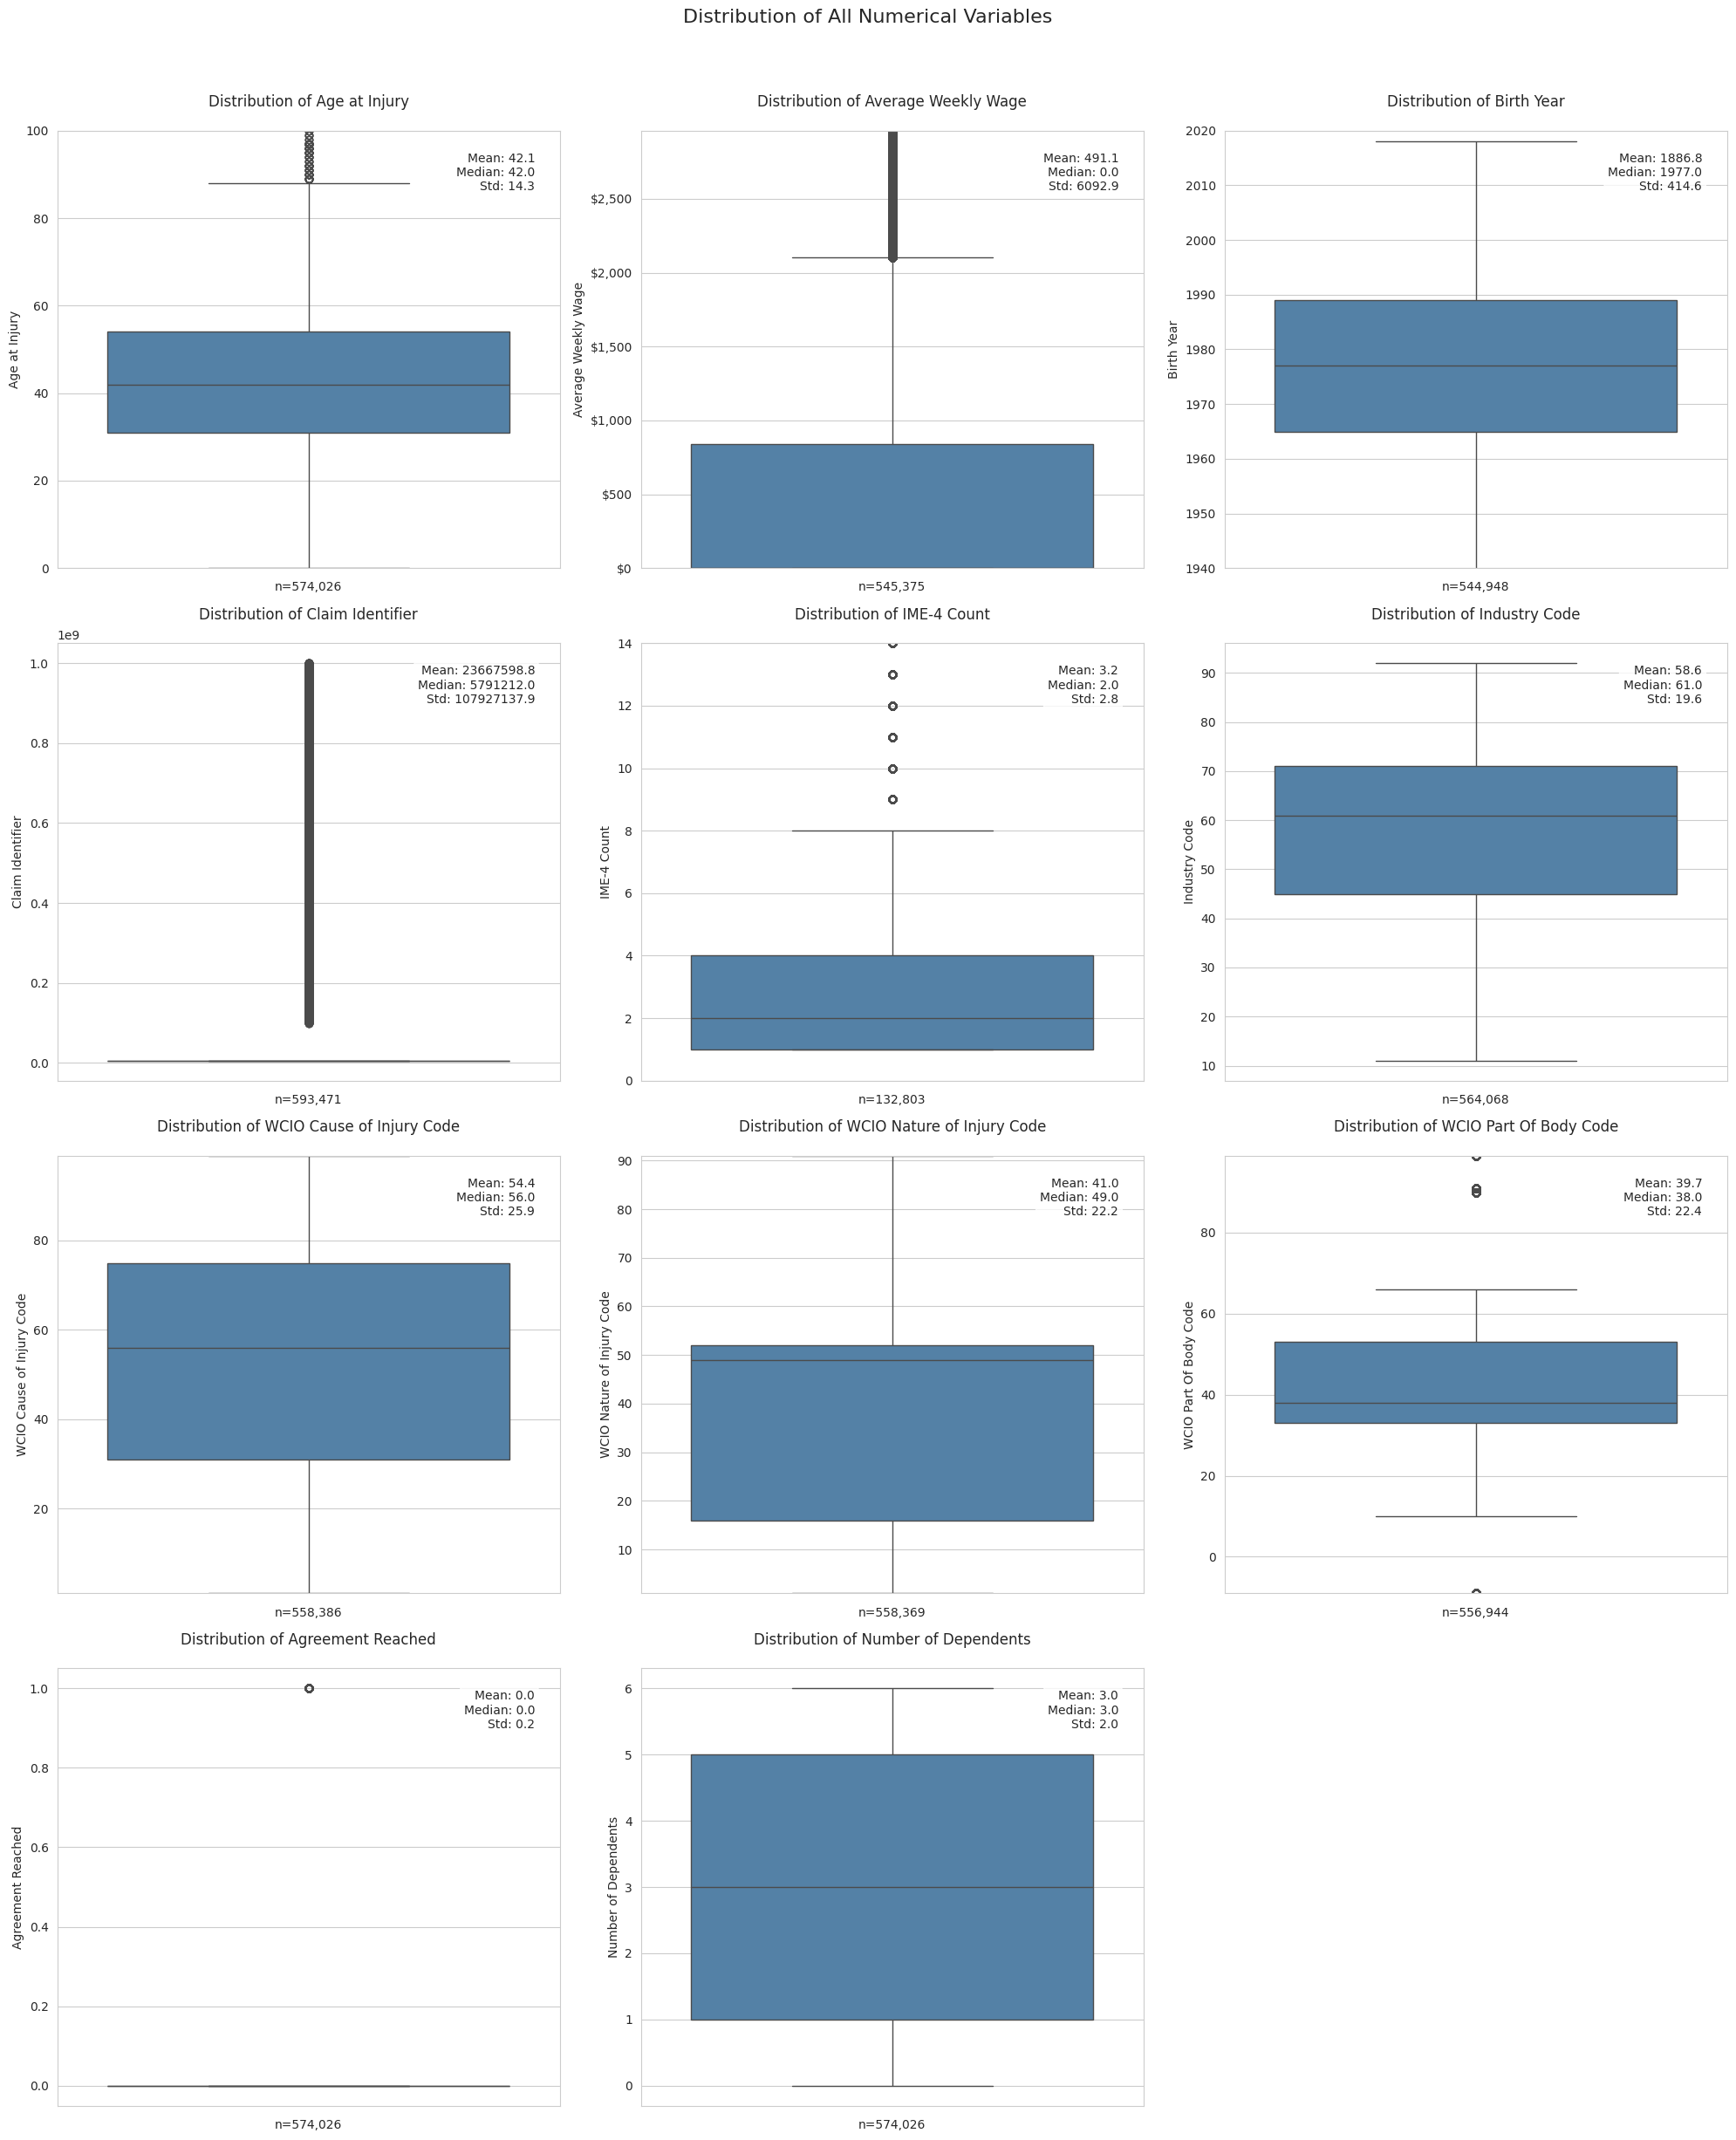


=== Age at Injury ===
count    574026.000000
mean         42.114270
std          14.256432
min           0.000000
25%          31.000000
50%          42.000000
75%          54.000000
max         117.000000
Name: Age at Injury, dtype: float64
Missing values: 19,445 (3.3%)
--------------------------------------------------

=== Average Weekly Wage ===
count    5.453750e+05
mean     4.910883e+02
std      6.092918e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.410000e+02
max      2.828079e+06
Name: Average Weekly Wage, dtype: float64
Missing values: 48,096 (8.1%)
--------------------------------------------------

=== Birth Year ===
count    544948.000000
mean       1886.767604
std         414.644423
min           0.000000
25%        1965.000000
50%        1977.000000
75%        1989.000000
max        2018.000000
Name: Birth Year, dtype: float64
Missing values: 48,523 (8.2%)
--------------------------------------------------

=== Claim Identifier ===
coun

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_comprehensive_boxplots(df):
    """
    Create boxplots for all relevant numerical columns with appropriate scaling
    """
    # Define numerical columns to plot
    numeric_cols = [
    'Age_at_Injury',                # Continuous
    'Average_Weekly_Wage',          # Continuous
    'Birth_Year',                   # Discrete
    'Claim_Identifier',             # Discrete
    'Industry_Code',                # Discrete
    'IME_4_Count',                  # Discrete
    'WCIO_Cause_of_Injury_Code',    # Discrete
    'WCIO_Nature_of_Injury_Code',   # Discrete
    'WCIO Part Of_Body_Code',       # Discrete
    'Number of Dependents',         # Discrete
    'Zip Length',                   # Discrete
    'Zip Code'                      # Discrete (could be categorical)
    ]

    # Calculate number of rows and columns for subplot grid
    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    fig.suptitle('Distribution of All Numerical Variables', fontsize=16, y=1.02)

    # Flatten axes array for easier iteration
    axes_flat = axes.flatten() if hasattr(axes, 'flatten') else [axes]

    for i, col in enumerate(numerical_cols):
        ax = axes_flat[i]

        # Create boxplot
        sns.boxplot(data=df, y=col, ax=ax, color='steelblue')

        # Calculate statistics
        stats = df[col].describe()
        stats_text = f'Mean: {stats["mean"]:.1f}\nMedian: {stats["50%"]:.1f}\nStd: {stats["std"]:.1f}'

        # Add statistics box
        ax.text(0.95, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Customize plot based on variable
        ax.set_title(f'Distribution of {col}', pad=20)

        # Add sample size
        ax.set_xlabel(f'n={df[col].notna().sum():,}')

        # Variable-specific customization
        if col == 'Average Weekly Wage':
            ax.set_ylim(0, df[col].quantile(0.99))  # Show up to 99th percentile
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        elif col == 'Birth Year':
            ax.set_ylim(1940, 2020)
        elif col == 'Age at Injury':
            ax.set_ylim(0, 100)
        elif col == 'IME-4 Count':
            ax.set_ylim(0, df[col].quantile(0.99))
        elif col in ['WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']:
            ax.set_ylim(df[col].min(), df[col].max())

    # Remove empty subplots if any
    for j in range(i + 1, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout()
    return fig

def print_numerical_summaries(df):
    """
    Print detailed summaries for all numerical columns
    """
    numeric_cols = [
    'Age_at_Injury',                # Continuous
    'Average_Weekly_Wage',          # Continuous
    'Birth_Year',                   # Discrete
    'Claim_Identifier',             # Discrete
    'Industry_Code',                # Discrete
    'IME_4_Count',                  # Discrete
    'WCIO_Cause_of_Injury_Code',    # Discrete
    'WCIO_Nature_of_Injury_Code',   # Discrete
    'WCIO_Part_Of_Body_Code',       # Discrete
    'Number_of_Dependents',         # Discrete
    'Zip_Length',                   # Discrete
    'Zip_Code'                      # Discrete (could be categorical)
    ]

    for col in numerical_cols:
        print(f"\n=== {col} ===")
        stats = df[col].describe()
        print(stats)
        print(f"Missing values: {df[col].isna().sum():,} ({df[col].isna().mean():.1%})")
        print("-" * 50)

# To use the functions:
fig = create_comprehensive_boxplots(train_df)
plt.show()
print_numerical_summaries(train_df)

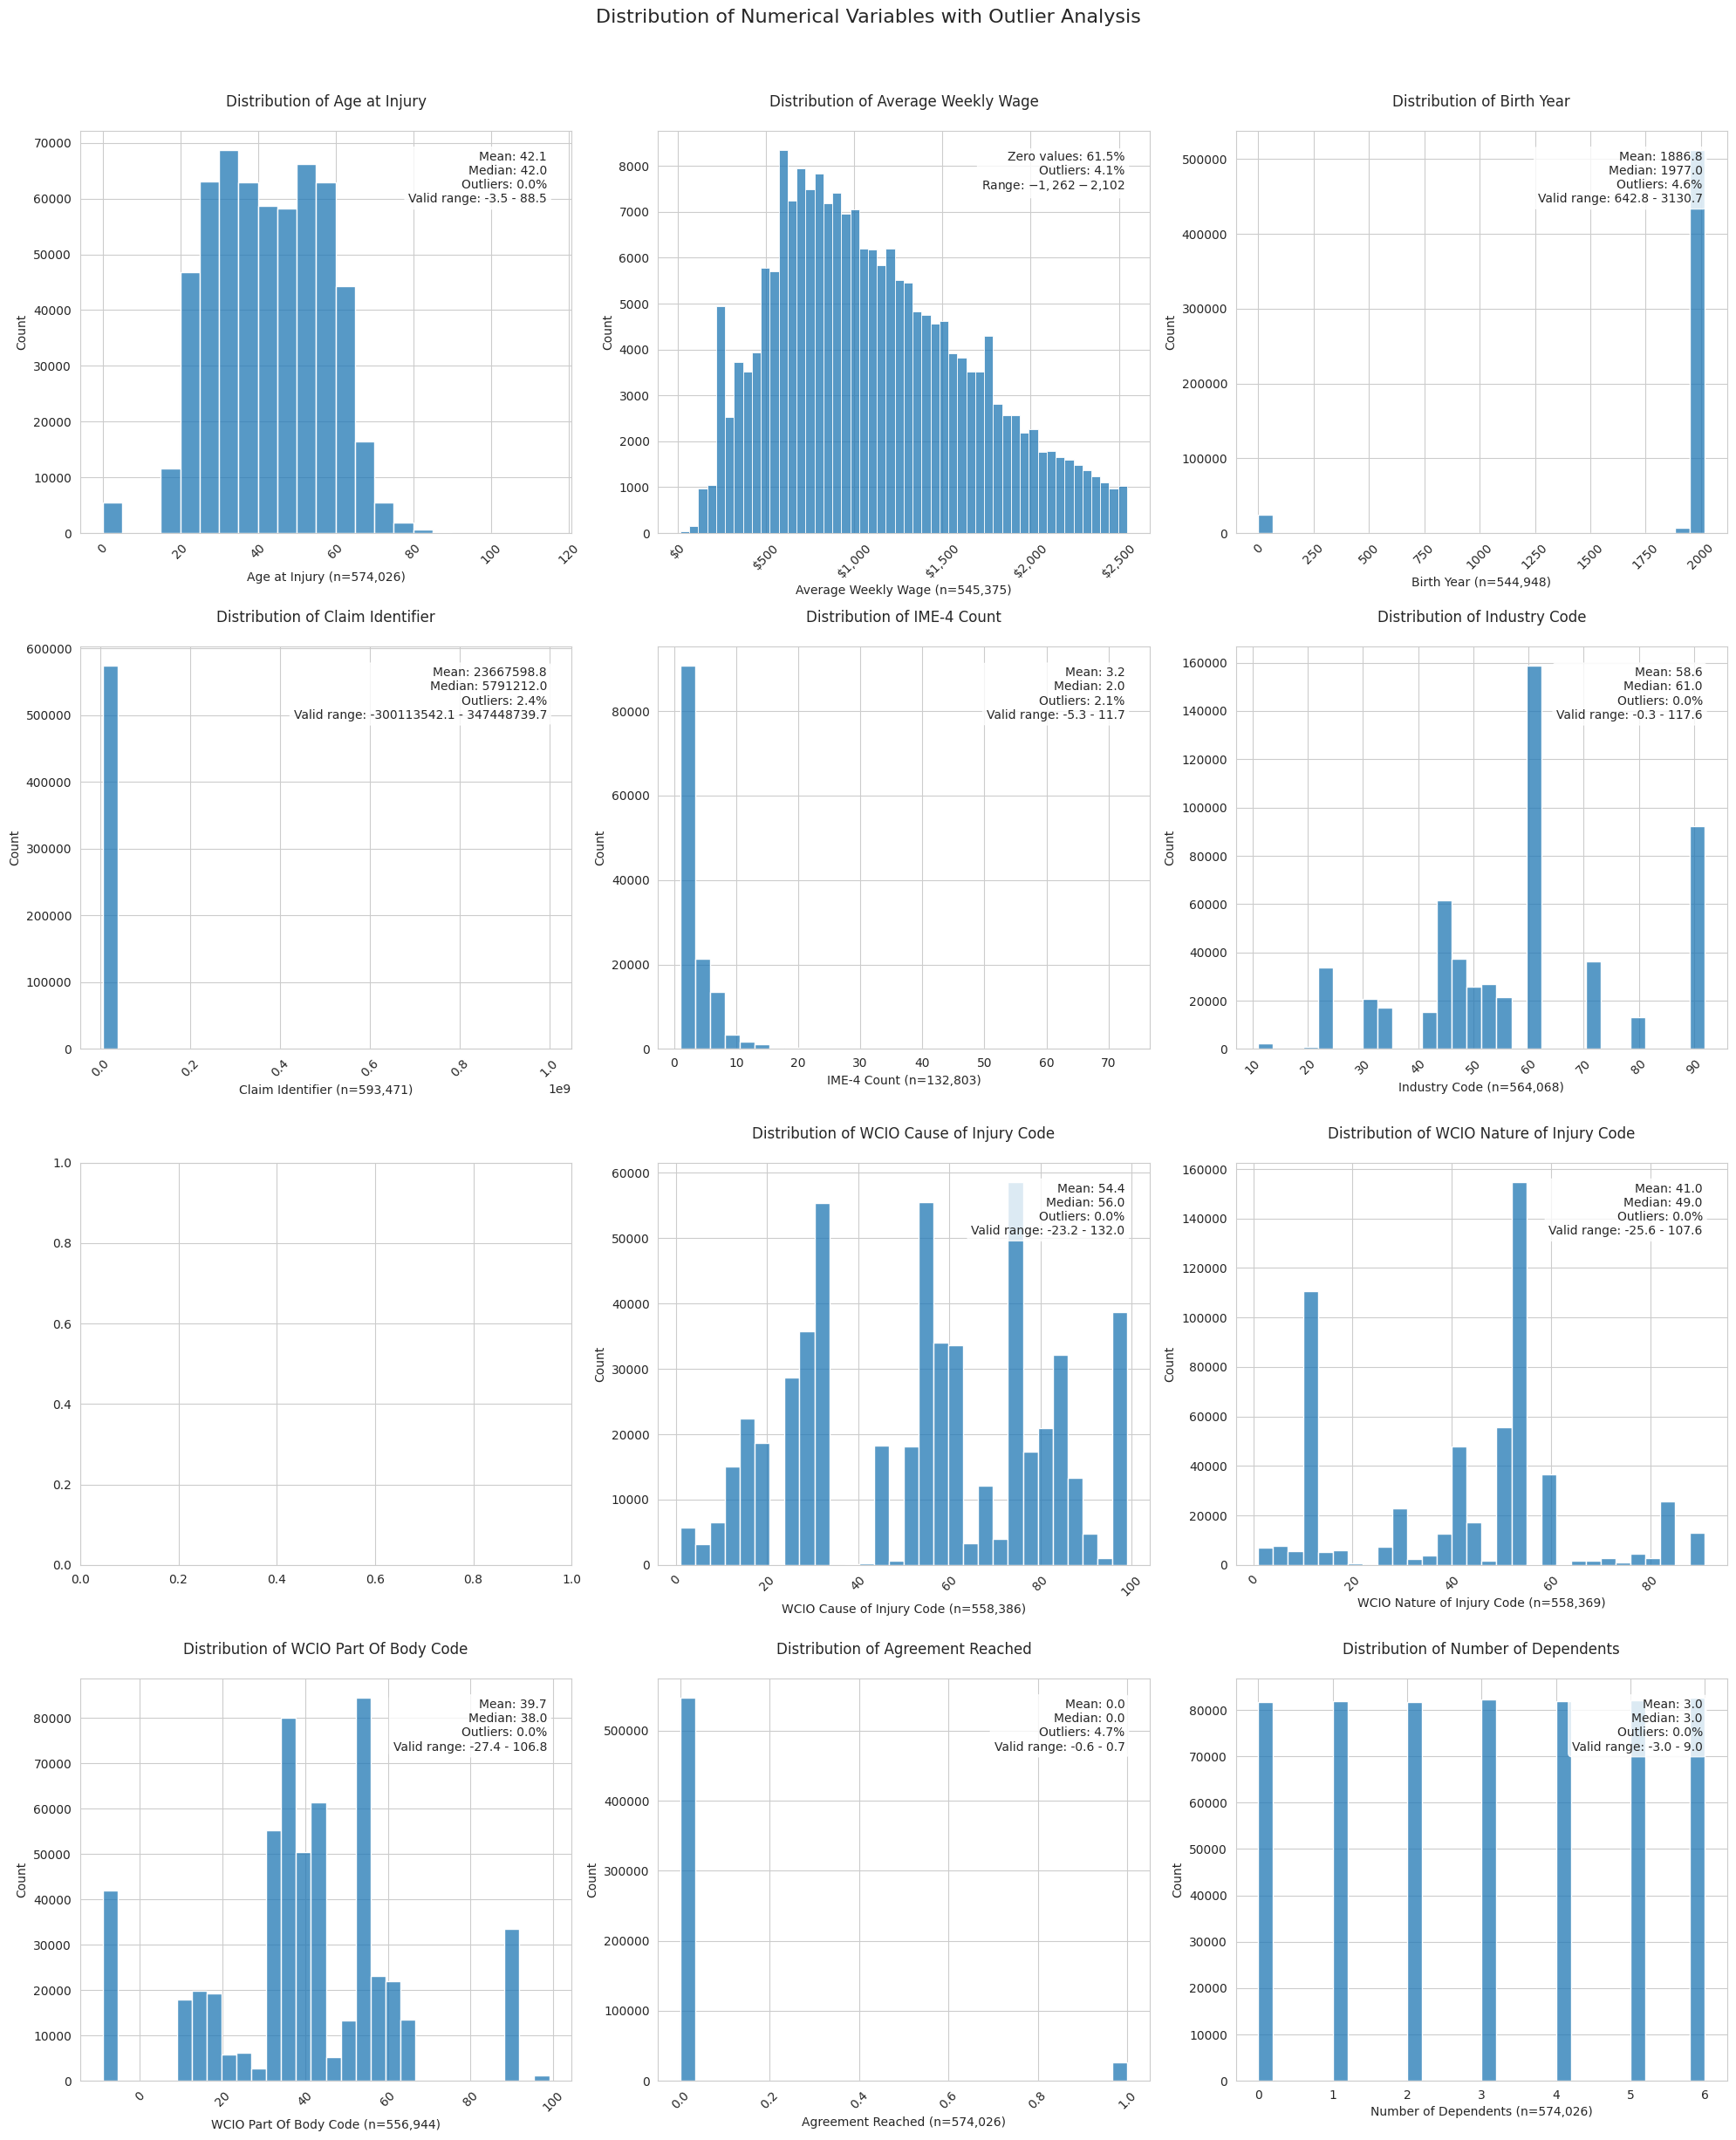


=== Age at Injury ===
count    574026.000000
mean         42.114270
std          14.256432
min           0.000000
25%          31.000000
50%          42.000000
75%          54.000000
max         117.000000
Name: Age at Injury, dtype: float64
Missing values: 19,445 (3.3%)

Outlier Analysis:
Z-score method (±3σ):
- Outliers: 340 (0.1%)
- Valid range: -0.7 to 84.9

IQR method (1.5×IQR):
- Outliers: 197 (0.0%)
- Valid range: -3.5 to 88.5

Distribution shape:
- Skewness: -0.04 (approximately symmetric)
- Kurtosis: -0.43 (normal-like)
--------------------------------------------------

=== Average Weekly Wage ===
count    5.453750e+05
mean     4.910883e+02
std      6.092918e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.410000e+02
max      2.828079e+06
Name: Average Weekly Wage, dtype: float64
Missing values: 48,096 (8.1%)
Zero values: 335,450 (56.5%)

Outlier Analysis:
Z-score method (±3σ):
- Outliers: 34 (0.0%)
- Valid range: -17787.6 to 18769.8

IQR meth

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def detect_outliers(series, method='zscore'):
    """
    Detect outliers using various methods

    Parameters:
    series: pandas Series - numerical data to analyze
    method: str - detection method ('zscore' or 'iqr')

    Returns:
    tuple: (outlier mask, lower bound, upper bound)
    """
    # Convert series to numpy array and handle missing values
    data = pd.to_numeric(series, errors='coerce').dropna().values

    if len(data) == 0:
        return np.array([]), np.nan, np.nan

    if method == 'zscore':
        z_scores = np.abs(stats.zscore(data))
        outliers = z_scores > 3
        lower_bound = np.mean(data) - 3 * np.std(data)
        upper_bound = np.mean(data) + 3 * np.std(data)
    else:  # IQR method
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = (data < lower_bound) | (data > upper_bound)

    return outliers, lower_bound, upper_bound

def create_histograms(df):
    """
    Create histograms for all numerical variables with appropriate binning, scaling,
    and outlier detection
    """
    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Calculate number of rows and columns for subplot grid
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    fig.suptitle('Distribution of Numerical Variables with Outlier Analysis', fontsize=16, y=1.02)

    # Flatten axes array for easier iteration
    axes_flat = axes.flatten() if hasattr(axes, 'flatten') else [axes]

    for i, col in enumerate(numeric_cols):
        ax = axes_flat[i]

        # Get non-null values for analysis
        valid_data = pd.to_numeric(df[col], errors='coerce').dropna()

        if len(valid_data) == 0:
            continue

        # Determine outlier detection method based on variable type
        outlier_method = 'iqr' if col in ['Average Weekly Wage', 'Age at Injury'] else 'zscore'

        # Detect outliers
        outliers, lower_bound, upper_bound = detect_outliers(valid_data, method=outlier_method)

        # Custom handling for each variable type
        if 'wage' in col.lower():
            # Plot non-zero wages up to 95th percentile
            non_zero_wages = valid_data[valid_data > 0]
            max_wage = non_zero_wages.quantile(0.95)
            sns.histplot(data=non_zero_wages[non_zero_wages <= max_wage],
                        bins=50, ax=ax)
            ax.set_xlabel(f'${col} (up to 95th percentile)')
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

            # Add text about zeros, outliers and anomalies
            zero_pct = (valid_data == 0).mean() * 100
            outlier_pct = np.mean(outliers) * 100
            stats_text = (f'Zero values: {zero_pct:.1f}%\n'
                         f'Outliers: {outlier_pct:.1f}%\n'
                         f'Range: ${lower_bound:,.0f} - ${upper_bound:,.0f}')

        elif 'age' in col.lower():
            sns.histplot(data=valid_data, bins=np.arange(0, 120, 5), ax=ax)
            stats_text = (f'Mean: {valid_data.mean():.1f}\n'
                         f'Median: {valid_data.median():.1f}\n'
                         f'Outliers: {np.mean(outliers):.1%}\n'
                         f'Valid range: {lower_bound:.1f} - {upper_bound:.1f}')

        else:  # For other numerical variables
            sns.histplot(data=valid_data, bins=30, ax=ax)
            stats_text = (f'Mean: {valid_data.mean():.1f}\n'
                         f'Median: {valid_data.median():.1f}\n'
                         f'Outliers: {np.mean(outliers):.1%}\n'
                         f'Valid range: {lower_bound:.1f} - {upper_bound:.1f}')

        # Add statistics
        ax.text(0.95, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Add title and sample size
        ax.set_title(f'Distribution of {col}', pad=20)
        n_samples = len(valid_data)
        ax.set_xlabel(f'{col} (n={n_samples:,})')

        # Rotate x-axis labels if needed
        if not any(x in col.lower() for x in ['dependent', 'count']):
            ax.tick_params(axis='x', rotation=45)

    # Remove empty subplots if any
    for j in range(i + 1, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout()
    return fig

def print_distribution_stats(df):
    """Print detailed distribution statistics including outlier analysis for each numerical variable"""
    # Get numeric columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    for col in numeric_cols:
        print(f"\n=== {col} ===")

        # Convert to numeric and drop invalid values
        valid_data = pd.to_numeric(df[col], errors='coerce')

        # Basic statistics
        stats_df = valid_data.describe()
        print(stats_df)

        # Missing values analysis
        missing_count = valid_data.isna().sum()
        missing_pct = valid_data.isna().mean()
        print(f"Missing values: {missing_count:,} ({missing_pct:.1%})")

        # Zero values analysis (if applicable)
        if 'wage' in col.lower():
            zero_count = (valid_data == 0).sum()
            zero_pct = (valid_data == 0).mean()
            print(f"Zero values: {zero_count:,} ({zero_pct:.1%})")

        # Outlier analysis
        valid_values = valid_data.dropna()
        if len(valid_values) > 0:
            try:
                # Detect outliers using both methods
                zscore_outliers, zscore_lower, zscore_upper = detect_outliers(valid_values, 'zscore')
                iqr_outliers, iqr_lower, iqr_upper = detect_outliers(valid_values, 'iqr')

                print("\nOutlier Analysis:")
                print(f"Z-score method (±3σ):")
                print(f"- Outliers: {np.sum(zscore_outliers):,} ({np.mean(zscore_outliers):.1%})")
                print(f"- Valid range: {zscore_lower:.1f} to {zscore_upper:.1f}")

                print(f"\nIQR method (1.5×IQR):")
                print(f"- Outliers: {np.sum(iqr_outliers):,} ({np.mean(iqr_outliers):.1%})")
                print(f"- Valid range: {iqr_lower:.1f} to {iqr_upper:.1f}")

                # Additional anomaly checks
                skewness = stats.skew(valid_values)
                kurtosis = stats.kurtosis(valid_values)
                print(f"\nDistribution shape:")
                print(f"- Skewness: {skewness:.2f} ({'highly skewed' if abs(skewness) > 1 else 'moderately skewed' if abs(skewness) > 0.5 else 'approximately symmetric'})")
                print(f"- Kurtosis: {kurtosis:.2f} ({'heavy-tailed' if kurtosis > 1 else 'light-tailed' if kurtosis < -1 else 'normal-like'})")

            except Exception as e:
                print(f"Error in outlier analysis: {str(e)}")

        print("-" * 50)

# Usage:
fig = create_histograms(train_df)
plt.show()
print_distribution_stats(train_df)

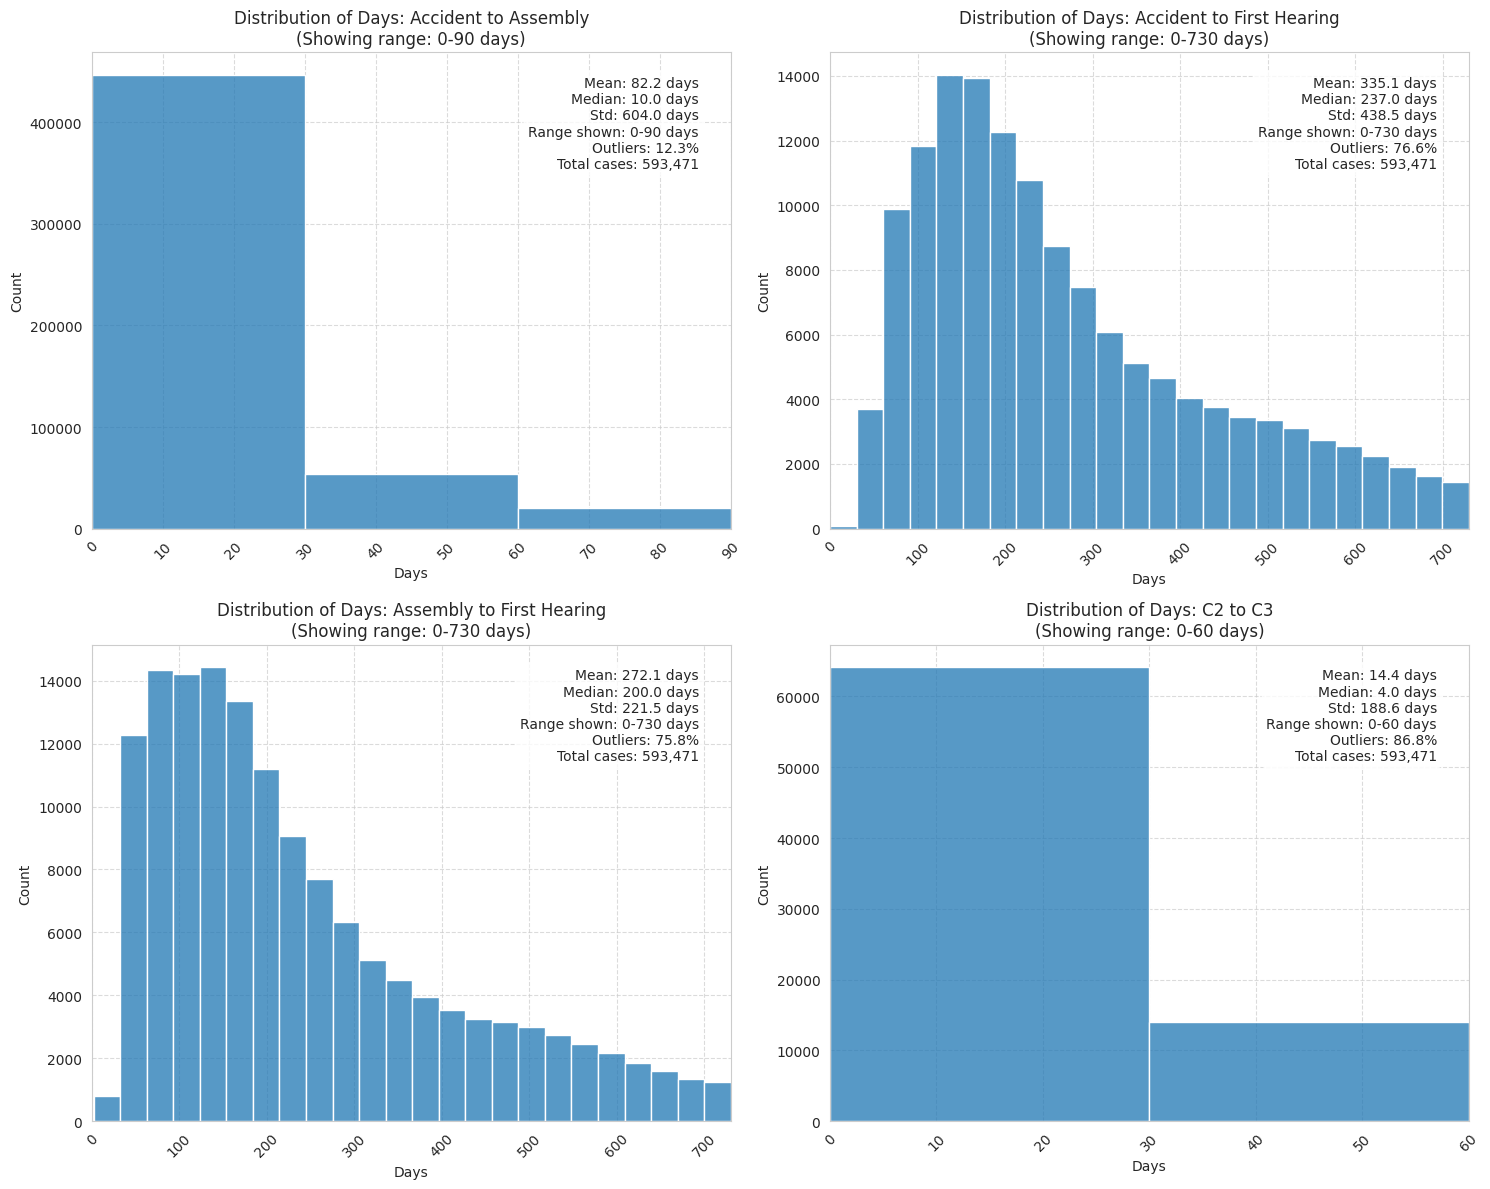


Detailed Interval Analysis:

Accident to Assembly:
--------------------------------------------------
Total cases: 593,471
Valid intervals: 570,337
Missing intervals: 23,134

Key percentiles (days):
25th percentile: 5.0
Median: 10.0
75th percentile: 24.0
90th percentile: 74.0
95th percentile: 165.0
99th percentile: 1007.0

Outlier analysis:
Negative intervals: 1,407 (0.2%)
Intervals > 1 year: 13,430 (2.3%)

Accident to First Hearing:
--------------------------------------------------
Total cases: 593,471
Valid intervals: 149,347
Missing intervals: 444,124

Key percentiles (days):
25th percentile: 147.0
Median: 237.0
75th percentile: 420.0
90th percentile: 646.0
95th percentile: 806.0
99th percentile: 1239.0

Outlier analysis:
Negative intervals: 74 (0.0%)
Intervals > 1 year: 45,196 (7.6%)

Assembly to First Hearing:
--------------------------------------------------
Total cases: 593,471
Valid intervals: 150,798
Missing intervals: 442,673

Key percentiles (days):
25th percentile: 115.0

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



def analyze_date_intervals(df):
    """
    Analyze intervals between different date variables with adjusted scales
    """
    # Convert date columns to datetime
    date_cols = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']
    date_df = df[date_cols].apply(pd.to_datetime, errors='coerce')

    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes_flat = axes.flatten()

    # Define intervals to analyze
    intervals = [
        ('Accident Date', 'Assembly Date', 'Accident to Assembly', 90),  # Show up to 90 days
        ('Accident Date', 'First Hearing Date', 'Accident to First Hearing', 730),  # Show up to 2 years
        ('Assembly Date', 'First Hearing Date', 'Assembly to First Hearing', 730),  # Show up to 2 years
        ('C-2 Date', 'C-3 Date', 'C2 to C3', 60)  # Show up to 60 days
    ]

    for idx, (start_date, end_date, label, max_days) in enumerate(intervals):
        if all(col in date_df.columns for col in [start_date, end_date]):
            # Calculate interval in days
            interval = (date_df[end_date] - date_df[start_date]).dt.days

            # Filter outliers for visualization but keep them for stats
            interval_filtered = interval[(interval >= 0) & (interval <= max_days)]

            # Plot distribution of intervals
            ax = axes_flat[idx]

            # Create histogram with appropriate bin size
            bin_size = max_days // 30  # Adjust number of bins based on range
            sns.histplot(data=interval_filtered, bins=bin_size, ax=ax)

            # Calculate statistics on full data
            stats = interval.describe()
            outliers_pct = (len(interval) - len(interval_filtered)) / len(interval) * 100

            # Add comprehensive statistics
            stats_text = (
                f"Mean: {stats['mean']:.1f} days\n"
                f"Median: {stats['50%']:.1f} days\n"
                f"Std: {stats['std']:.1f} days\n"
                f"Range shown: 0-{max_days} days\n"
                f"Outliers: {outliers_pct:.1f}%\n"
                f"Total cases: {len(interval):,}"
            )

            ax.text(0.95, 0.95, stats_text,
                   transform=ax.transAxes,
                   verticalalignment='top',
                   horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            ax.set_title(f'Distribution of Days: {label}\n(Showing range: 0-{max_days} days)')
            ax.set_xlabel('Days')
            ax.set_ylabel('Count')

            # Set x-axis limits
            ax.set_xlim(0, max_days)

            # Add gridlines for better readability
            ax.grid(True, linestyle='--', alpha=0.7)

            # Rotate x-axis labels for better readability
            ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    return fig

def print_interval_details(df):
    """
    Print detailed statistics about the intervals
    """
    date_cols = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']
    date_df = df[date_cols].apply(pd.to_datetime, errors='coerce')

    intervals = [
        ('Accident Date', 'Assembly Date', 'Accident to Assembly'),
        ('Accident Date', 'First Hearing Date', 'Accident to First Hearing'),
        ('Assembly Date', 'First Hearing Date', 'Assembly to First Hearing'),
        ('C-2 Date', 'C-3 Date', 'C2 to C3')
    ]

    print("\nDetailed Interval Analysis:")
    print("="*80)

    for start_date, end_date, label in intervals:
        if all(col in date_df.columns for col in [start_date, end_date]):
            interval = (date_df[end_date] - date_df[start_date]).dt.days

            print(f"\n{label}:")
            print("-"*50)
            print(f"Total cases: {len(interval):,}")
            print(f"Valid intervals: {interval.notna().sum():,}")
            print(f"Missing intervals: {interval.isna().sum():,}")

            # Calculate percentiles
            percentiles = interval.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
            print("\nKey percentiles (days):")
            print(f"25th percentile: {percentiles[0.25]:.1f}")
            print(f"Median: {percentiles[0.5]:.1f}")
            print(f"75th percentile: {percentiles[0.75]:.1f}")
            print(f"90th percentile: {percentiles[0.9]:.1f}")
            print(f"95th percentile: {percentiles[0.95]:.1f}")
            print(f"99th percentile: {percentiles[0.99]:.1f}")

            # Calculate negative and extreme positive intervals
            neg_intervals = (interval < 0).sum()
            extreme_intervals = (interval > 365).sum()

            print("\nOutlier analysis:")
            print(f"Negative intervals: {neg_intervals:,} ({neg_intervals/len(interval)*100:.1f}%)")
            print(f"Intervals > 1 year: {extreme_intervals:,} ({extreme_intervals/len(interval)*100:.1f}%)")

# To use these functions:
fig = analyze_date_intervals(train_df)
plt.show()
print_interval_details(train_df)

# Categorical variable analysis


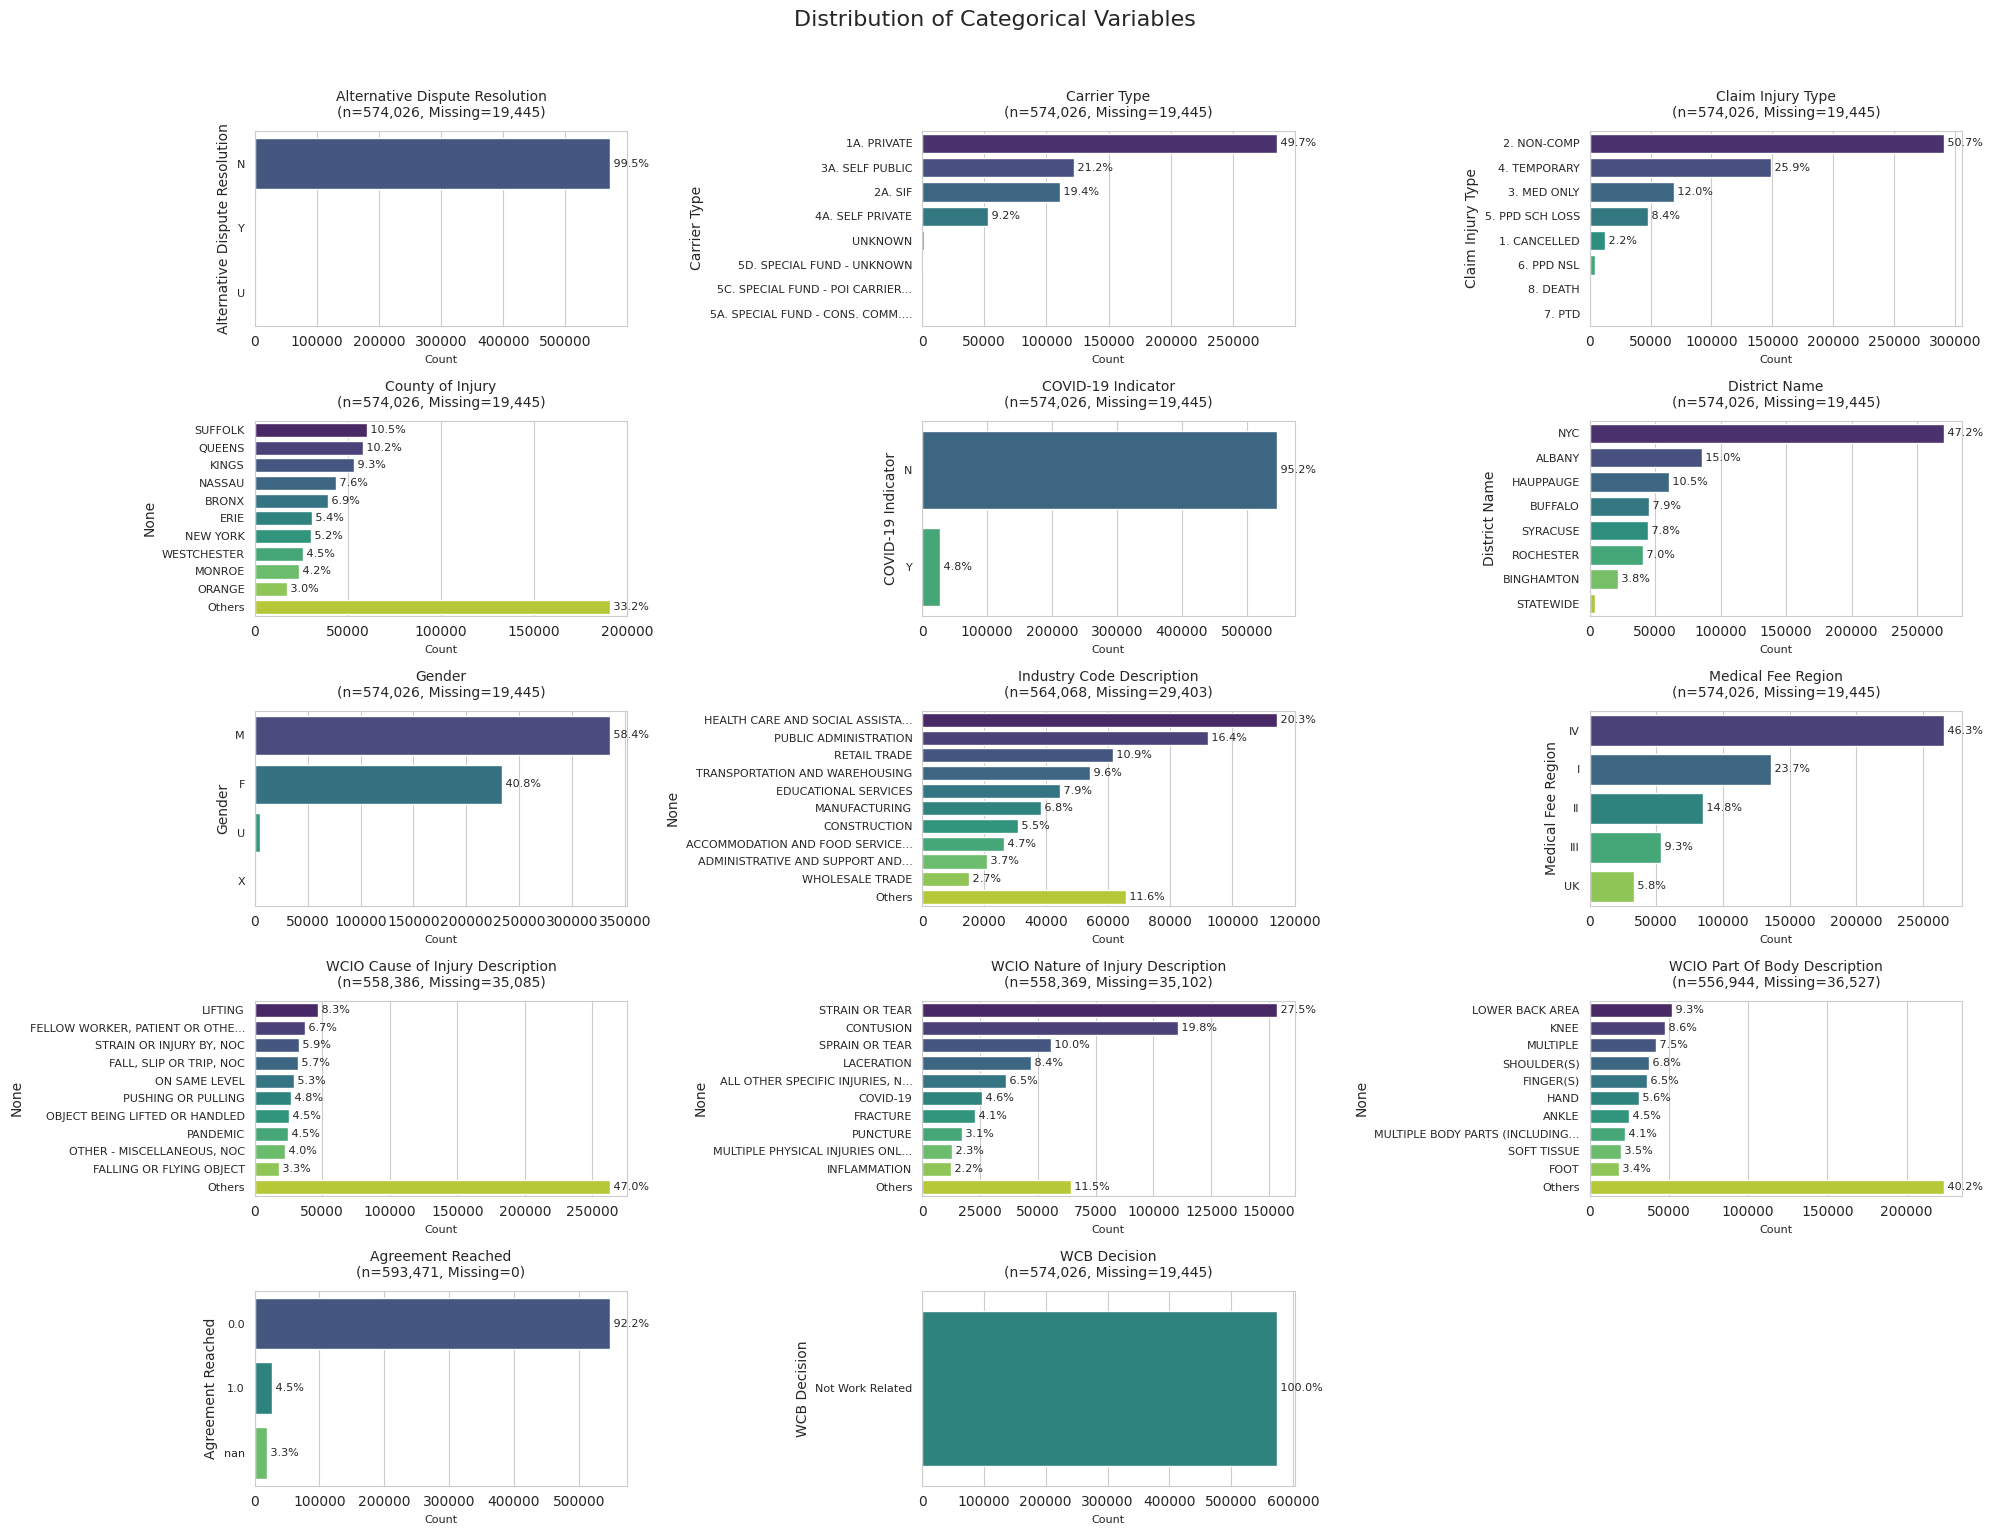

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_categorical_distributions(data, figsize=(20, 15), max_categories=10):
    """
    Create bar plots for categorical variables with proper formatting and handling of multiple categories
    """
    # Set the style using seaborn
    sns.set_style("whitegrid")

    # Define categorical columns and verify their presence in the data
    categorical_columns = [
        'Alternative Dispute Resolution',
        'Attorney Representative',
        'Carrier Type',
        'Claim Injury Type',  # Fixed underscore
        'County of Injury',
        'COVID-19 Indicator',
        'District Name',
        'Gender',
        'Industry Code Description',
        'Medical Fee Region',
        'WCIO Cause of Injury Description',
        'WCIO Nature of Injury Description',
        'WCIO Part Of Body Description',
        'Agreement Reached',
        'WCB Decision'
    ]

    # Filter to only include columns that exist in the dataframe
    available_columns = [col for col in categorical_columns if col in data.columns]

    if not available_columns:
        raise ValueError("None of the specified categorical columns found in the dataframe")

    # Calculate number of rows needed (3 columns)
    n_cols = 3
    n_rows = (len(available_columns) + n_cols - 1) // n_cols

    # Create figure with a reasonable size
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Distribution of Categorical Variables', fontsize=16, y=1.02)

    # Ensure axes is always a 2D array
    if n_rows == 1:
        axes = np.array([axes])
    if n_cols == 1:
        axes = axes.reshape(-1, 1)

    # Flatten axes for iteration
    axes_flat = axes.flatten()

    for idx, column in enumerate(available_columns):
        try:
            ax = axes_flat[idx]

            # Convert to string if necessary and get value counts
            if data[column].dtype == 'object' or pd.api.types.is_categorical_dtype(data[column]):
                series = data[column]
            else:
                series = data[column].astype(str)

            value_counts = series.value_counts()

            # Handle cases with many categories
            if len(value_counts) > max_categories:
                main_categories = value_counts.head(max_categories)
                others_sum = value_counts[max_categories:].sum()
                value_counts = pd.concat([main_categories, pd.Series({'Others': others_sum})])

            # Create bar plot
            bars = sns.barplot(x=value_counts.values, y=value_counts.index, ax=ax, palette='viridis')

            # Add title and labels
            ax.set_title(f'{column}\n(n={series.notna().sum():,}, Missing={series.isna().sum():,})',
                        fontsize=10, pad=10)
            ax.set_xlabel('Count', fontsize=8)

            # Add percentage labels on bars
            total = value_counts.sum()
            for i, v in enumerate(value_counts.values):
                percentage = (v/total) * 100
                if percentage >= 1:  # Only show percentages >= 1%
                    ax.text(v, i, f' {percentage:.1f}%', va='center', fontsize=8)

            # Adjust layout for better readability
            ax.tick_params(axis='y', labelsize=8)

            # Limit label length if too long
            labels = [str(label)[:30] + '...' if len(str(label)) > 30 else str(label)
                     for label in value_counts.index]
            ax.set_yticklabels(labels)

        except Exception as e:
            print(f"Error plotting {column}: {str(e)}")
            ax.text(0.5, 0.5, f"Error plotting {column}", ha='center', va='center')

    # Remove empty subplots if any
    for j in range(len(available_columns), len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout()
    return fig

def plot_detailed_categorical(data, column, figsize=(12, 6)):
    """
    Create a detailed bar plot for a specific categorical variable
    """
    sns.set_style("whitegrid")

    try:
        plt.figure(figsize=figsize)

        # Convert to string if necessary
        if data[column].dtype != 'object' and not pd.api.types.is_categorical_dtype(data[column]):
            series = data[column].astype(str)
        else:
            series = data[column]

        value_counts = series.value_counts()
        total = len(data)

        # Create bar plot
        ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')

        # Add title and labels
        plt.title(f'Distribution of {column}\n(n={series.notna().sum():,}, Missing={series.isna().sum():,})')
        plt.xlabel(column)
        plt.ylabel('Count')

        # Add percentage labels
        for i, v in enumerate(value_counts.values):
            percentage = (v/total) * 100
            if percentage >= 1:  # Only show percentages >= 1%
                ax.text(i, v, f'{percentage:.1f}%', ha='center', va='bottom')

        # Rotate x-labels if needed
        if len(value_counts.index) > 5 or max(len(str(x)) for x in value_counts.index) > 10:
            plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        return plt.gcf()

    except Exception as e:
        plt.close()
        print(f"Error plotting {column}: {str(e)}")
        return None

# Example usage:
# Plot all categorical variables
fig = plot_categorical_distributions(train_df)
plt.show()


In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_categorical_anomalies(data, categorical_threshold=0.01):
    """
    Performs comprehensive anomaly analysis on categorical variables.

    Parameters:
    -----------
    data : pandas.DataFrame
        Input dataset to analyze
    categorical_threshold : float
        Minimum frequency threshold for rare categories (default: 0.01 or 1%)

    Returns:
    --------
    dict
        Dictionary containing analysis results
    """
    results = {
        'categorical_anomalies': {},
        'summary': {'total_rare_categories': 0}
    }

    def analyze_categorical_column(series):
        """Helper function to analyze categorical columns"""
        # Remove null values for analysis
        series = series.dropna()

        # Calculate value frequencies
        value_counts = series.value_counts(normalize=True)
        rare_categories = value_counts[value_counts < categorical_threshold]

        # Calculate absolute counts for reporting
        absolute_counts = series.value_counts()

        return {
            'rare_categories': rare_categories.index.tolist(),
            'rare_frequencies': rare_categories.values.tolist(),
            'rare_absolute_counts': [absolute_counts[cat] for cat in rare_categories.index],
            'total_rare_categories': len(rare_categories),
            'most_common': value_counts.index[0],
            'most_common_freq': value_counts.iloc[0],
            'unique_categories': len(value_counts),
            'missing_values': series.isnull().sum(),
            'total_records': len(series)
        }

    # Analyze categorical columns
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns

    for col in categorical_cols:
        if data[col].notna().any():  # Only analyze if column has non-null values
            results['categorical_anomalies'][col] = analyze_categorical_column(data[col])
            results['summary']['total_rare_categories'] += results['categorical_anomalies'][col]['total_rare_categories']

    return results

def plot_category_distributions(data, results, column, figsize=(12, 6)):
    """
    Creates visualization for category distribution with rare categories highlighted.

    Parameters:
    -----------
    data : pandas.DataFrame
        Input dataset
    results : dict
        Results from analyze_categorical_anomalies function
    column : str
        Column name to visualize
    figsize : tuple
        Figure size for plot
    """
    if column not in results['categorical_anomalies']:
        print(f"No analysis results found for column: {column}")
        return None

    plt.figure(figsize=figsize)

    # Get column data
    series = data[column].dropna()
    value_counts = series.value_counts()

    # Create color map (rare categories in red, others in blue)
    rare_cats = set(results['categorical_anomalies'][column]['rare_categories'])
    colors = ['red' if cat in rare_cats else 'blue' for cat in value_counts.index]

    # Create bar plot
    ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette=colors)

    # Add title and labels
    stats = results['categorical_anomalies'][column]
    title = (f'Distribution of {column}\n'
             f'Total Categories: {stats["unique_categories"]}, '
             f'Rare Categories: {stats["total_rare_categories"]}\n'
             f'Missing Values: {stats["missing_values"]} '
             f'({stats["missing_values"]/stats["total_records"]*100:.1f}%)')

    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Count')

    # Add percentage labels
    total = len(series)
    for i, v in enumerate(value_counts.values):
        percentage = (v/total) * 100
        if percentage >= 1:  # Only show percentages >= 1%
            ax.text(i, v, f'{percentage:.1f}%', ha='center', va='bottom')

    # Rotate x-labels if needed
    if len(value_counts.index) > 5 or max(len(str(x)) for x in value_counts.index) > 10:
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    return plt.gcf()

def generate_categorical_analysis_report(data, categorical_threshold=0.01):
    """
    Generates a comprehensive categorical anomaly analysis report.

    Parameters:
    -----------
    data : pandas.DataFrame
        Input dataset to analyze
    categorical_threshold : float
        Minimum frequency threshold for rare categories

    Returns:
    --------
    tuple
        (analysis_results, summary_text)
    """
    # Perform analysis
    results = analyze_categorical_anomalies(data, categorical_threshold)

    # Generate summary report
    summary = []
    summary.append("=== Categorical Anomaly Analysis Report ===\n")

    # Overall summary
    summary.append(f"Total number of rare categories detected: {results['summary']['total_rare_categories']}")
    summary.append(f"Analysis threshold: Categories occurring in less than {categorical_threshold*100}% of records\n")

    # Detailed categorical analysis
    summary.append("=== Categorical Variables Analysis ===")
    for col, stats in results['categorical_anomalies'].items():
        summary.append(f"\n{col}:")
        summary.append(f"- Total unique categories: {stats['unique_categories']}")
        summary.append(f"- Missing values: {stats['missing_values']} ({stats['missing_values']/stats['total_records']*100:.1f}%)")
        summary.append(f"- Most common value: {stats['most_common']} ({stats['most_common_freq']*100:.1f}%)")
        summary.append(f"- Number of rare categories: {stats['total_rare_categories']}")

        if stats['total_rare_categories'] > 0:
            summary.append("- Rare categories (top 5):")
            for cat, freq, count in zip(
                stats['rare_categories'][:5],
                stats['rare_frequencies'][:5],
                stats['rare_absolute_counts'][:5]
            ):
                summary.append(f"  * {cat}: {count} occurrences ({freq*100:.2f}%)")

    return results, "\n".join(summary)

# Example usage:

# Analyze the data
results, report = generate_categorical_analysis_report(data)
print(report)

# Create visualization for a specific column
fig = plot_category_distributions(data, results, 'your_column_name')
plt.show()


=== Categorical Anomaly Analysis Report ===

Total number of rare categories detected: 22344
Analysis threshold: Categories occurring in less than 1.0% of records

=== Categorical Variables Analysis ===

Accident Date:
- Total unique categories: 5539
- Missing values: 0 (0.0%)
- Most common value: 2020-03-01 (0.2%)
- Number of rare categories: 5539
- Rare categories (top 5):
  * 2020-03-01: 1245 occurrences (0.22%)
  * 2020-12-18: 1001 occurrences (0.18%)
  * 2022-02-07: 977 occurrences (0.17%)
  * 2022-01-05: 883 occurrences (0.15%)
  * 2021-02-18: 851 occurrences (0.15%)

Alternative Dispute Resolution:
- Total unique categories: 3
- Missing values: 0 (0.0%)
- Most common value: N (99.5%)
- Number of rare categories: 2
- Rare categories (top 5):
  * Y: 2609 occurrences (0.45%)
  * U: 5 occurrences (0.00%)

Assembly Date:
- Total unique categories: 1096
- Missing values: 0 (0.0%)
- Most common value: 2020-03-06 (0.2%)
- Number of rare categories: 1096
- Rare categories (top 5):
  * 20

In [91]:
pd.set_option('display.max_columns', None)
train_df.head(50)
train_df.describe()

,Age at Injury,Average Weekly Wage,Birth Year,Claim Identifier,IME-4 Count,Industry Code,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents
count,574026.000000,5.453750e+05,544948.000000,5.934710e+05,132803.000000,564068.000000,0.0,558386.000000,558369.000000,556944.000000,574026.000000,574026.000000
mean,42.114270,4.910883e+02,1886.767604,2.366760e+07,3.207337,58.645305,NaN,54.381143,41.013839,39.738146,0.046665,3.006559
std,14.256432,6.092918e+03,414.644423,1.079271e+08,2.832303,19.644175,NaN,25.874281,22.207521,22.365940,0.210921,2.000801
min,0.000000,0.000000e+00,0.000000,5.393066e+06,1.000000,11.000000,NaN,1.000000,1.000000,-9.000000,0.000000,0.000000
25%,31.000000,0.000000e+00,1965.000000,5.593414e+06,1.000000,45.000000,NaN,31.000000,16.000000,33.000000,0.000000,1.000000
50%,42.000000,0.000000e+00,1977.000000,5.791212e+06,2.000000,61.000000,NaN,56.000000,49.000000,38.000000,0.000000,3.000000
75%,54.000000,8.410000e+02,1989.000000,5.991000e+06,4.000000,71.000000,NaN,75.000000,52.000000,53.000000,0.000000,5.000000
max,117.000000,2.828079e+06,2018.000000,9.998917e+08,73.000000,92.000000,NaN,99.000000,91.000000,99.000000,1.000000,6.000000


# **Dealing with outliers and anomalies**

Numerical outliers & Anomalies


Average Weekly Wage > KNN- imputer

Highly problematic distribution with severe anomalies:
56.5% zero values, suggesting massive data quality issues or misreporting
Extreme right skew (378.98) and kurtosis (160,019.57)
Maximum value of $2.8M appears implausible for weekly wage
IQR method identifies 4.1% outliers, more reliable than z-score due to non-normal distribution
Recommendation: Implement wage validation rules and investigate zero-value cases


Birth Year

Severe data quality issues evident:
Range from 0 to 2018 is impossible for worker birth years
4.6% outliers identified by both methods
Valid range should be approximately 1929-2025 (IQR method)
Many impossible values (year 0) need cleaning
Recommendation: Implement strict validation rules for birth year entries


Age at Injury

Generally well-behaved but with some concerns:
Range 0-117 years includes implausible values
Only 0.1% outliers (z-score method)
Nearly symmetric distribution (skewness -0.04)
Recommendation: Flag cases with age > 80 for verification

IME-4 Count

High missing rate (77.6%) is concerning
Right-skewed distribution (2.59)
Maximum of 73 counts seems unusually high
5.4% outliers by IQR method
Recommendation: Investigate cases with counts > 8


WCIO Part of Body Code

Unusual negative values (minimum -9)
High outlier rate (13.8%) by IQR method
Needs standardization to valid codes
Recommendation: Clean negative values and validate against standard codes

In [190]:
import numpy as np
import pandas as pd

def clean_age(df):
    """Convert invalid ages to NaN"""
    print("Initial valid values:", df['Age at Injury'].notna().sum())

    # Set valid age range
    min_age = 16
    max_age = 85

    # Convert invalid ages to NaN
    df['Age at Injury'] = df['Age at Injury'].mask(
        ~((df['Age at Injury'] >= min_age) &
          (df['Age at Injury'] <= max_age) &
          (df['Age at Injury'].notna())),
        np.nan
    )

    print(f"Remaining valid values: {df['Age at Injury'].notna().sum()}")
    return df

def clean_birth_year(df):
    """Convert invalid birth years to NaN"""
    print("Initial valid values:", df['Birth Year'].notna().sum())

    current_year = 2024
    min_age = 16
    max_age = 100

    # Calculate valid range
    min_birth_year = current_year - max_age
    max_birth_year = current_year - min_age

    # Convert invalid birth years to NaN
    df['Birth Year'] = df['Birth Year'].mask(
        ~((df['Birth Year'] >= min_birth_year) &
          (df['Birth Year'] <= max_birth_year) &
          (df['Birth Year'].notna())),
        np.nan
    )

    print(f"Remaining valid values: {df['Birth Year'].notna().sum()}")
    return df

def clean_ime_count(df):
    """Convert suspiciously high IME counts to NaN"""
    print("Initial valid values:", df['IME-4 Count'].notna().sum())

    # Convert invalid IME counts to NaN, keeping NA values as is
    df['IME-4 Count'] = df['IME-4 Count'].mask(
        ~(df['IME-4 Count'].isna() |
          ((df['IME-4 Count'] <= 15) & (df['IME-4 Count'] >= 0))),
        np.nan
    )

    print(f"Remaining valid values: {df['IME-4 Count'].notna().sum()}")
    return df

def clean_body_codes(df):
    """Convert invalid body codes to NaN"""
    print("Initial valid values:", df['WCIO Part Of Body Code'].notna().sum())

    valid_codes = range(1, 100)  # Replace with actual valid codes

    # Convert invalid codes to NaN, keeping NA values as is
    df['WCIO Part Of Body Code'] = df['WCIO Part Of Body Code'].mask(
        ~(df['WCIO Part Of Body Code'].isna() |
          ((df['WCIO Part Of Body Code'] >= 0) &
           (df['WCIO Part Of Body Code'].isin(valid_codes)))),
        np.nan
    )

    print(f"Remaining valid values: {df['WCIO Part Of Body Code'].notna().sum()}")
    return df

# Create a copy of the original dataframe
clean_train_df = train_df.copy()
print(f"Original dataset size: {len(clean_train_df):,}")

# Apply cleaning pipeline
print("\nStarting data cleaning pipeline...")

# Apply each cleaning function sequentially
clean_train_df = clean_age(clean_train_df)
clean_train_df = clean_birth_year(clean_train_df)
clean_train_df = clean_ime_count(clean_train_df)
clean_train_df = clean_body_codes(clean_train_df)

# Create cleaning summary
print("\n=== Cleaning Summary ===")
print("Original vs Remaining Valid Values:")
numeric_cols = ['Age at Injury', 'Birth Year', 'IME-4 Count', 'WCIO Part Of Body Code']

for col in numeric_cols:
    if col in clean_train_df.columns:
        original_valid = train_df[col].notna().sum()
        remaining_valid = clean_train_df[col].notna().sum()
        converted_to_nan = original_valid - remaining_valid
        print(f"\n{col}:")
        print(f"Original valid values: {original_valid:,}")
        print(f"Remaining valid values: {remaining_valid:,}")
        print(f"Converted to NaN: {converted_to_nan:,} ({(converted_to_nan/len(clean_train_df)*100):.1f}%)")

# Compare distributions before and after
print("\n=== Distribution Comparison ===")
for col in numeric_cols:
    if col in clean_train_df.columns:
        print(f"\n{col}:")
        print("Before cleaning:")
        print(train_df[col].describe())
        print("\nAfter cleaning:")
        print(clean_train_df[col].describe())

# Verify remaining valid values are within expected ranges
print("\n=== Validation Checks ===")
for col in numeric_cols:
    if col in clean_train_df.columns:
        valid_values = clean_train_df[clean_train_df[col].notna()][col]
        if len(valid_values) > 0:
            print(f"\n{col} valid range:")
            print(f"Min: {valid_values.min()}")
            print(f"Max: {valid_values.max()}")
            print(f"Valid values: {len(valid_values):,} ({(len(valid_values)/len(clean_train_df)*100):.1f}%)")

Original dataset size: 593,471

Starting data cleaning pipeline...
Initial valid values: 574026
Remaining valid values: 568057
Initial valid values: 544948
Remaining valid values: 519686
Initial valid values: 132803
Remaining valid values: 132003
Initial valid values: 556944
Remaining valid values: 514933

=== Cleaning Summary ===
Original vs Remaining Valid Values:

Age at Injury:
Original valid values: 574,026
Remaining valid values: 568,057
Converted to NaN: 5,969 (1.0%)

Birth Year:
Original valid values: 544,948
Remaining valid values: 519,686
Converted to NaN: 25,262 (4.3%)

IME-4 Count:
Original valid values: 132,803
Remaining valid values: 132,003
Converted to NaN: 800 (0.1%)

WCIO Part Of Body Code:
Original valid values: 556,944
Remaining valid values: 514,933
Converted to NaN: 42,011 (7.1%)

=== Distribution Comparison ===

Age at Injury:
Before cleaning:
count    574026.000000
mean         42.114270
std          14.256432
min           0.000000
25%          31.000000
50%   

In [192]:
clean_train_df

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,5393875,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,NaN,M,NaN,44.0,RETAIL TRADE,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,5393091,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,CONSTRUCTION,I,NaN,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,5393889,4. TEMPORARY,ORANGE,N,ALBANY,NaN,M,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,957648180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,2A. SIF,5393887,2. NON-COMP,DUTCHESS,N,ALBANY,NaN,M,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,II,NaN,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593466,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327160035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593467,2022-12-13,72.0,N,2022-12-31,N,0.00,1950.0,2022-12-31,NaN,TECHNOLOGY INSURANCE CO. INC.,1A. PRIVATE,6165075,2. NON-COMP,SULLIVAN,N,BINGHAMTON,NaN,F,NaN,48.0,TRANSPORTATION AND WAREHOUSING,I,NaN,25.0,FROM DIFFERENT LEVEL (ELEVATION),90.0,MULTIPLE PHYSICAL INJURIES ONLY,NaN,MULTIPLE,12779,0.0,Not Work Related,3.0
593468,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249875936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593469,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120584215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Create a 5% sample
sample_size = int(len(train_df) * 0.02)
sample_df = train_df.sample(n=sample_size, random_state=42)

# Run imputation on the sample
sample_results = preprocess_and_impute_wages(sample_df)

# Analyze the sample results
sample_metrics = analyze_imputation_results(sample_results)

# Print metrics
print("Sample Imputation Metrics:")
for key, value in sample_metrics.items():
    print(f"{key}: {value}")

# Create a copy of train_df with imputed values
train_df_imputed = train_df.copy()

# Map the imputed values back to the original dataframe
imputed_wage_map = dict(zip(sample_results.index, sample_results['Imputed_Wage']))
train_df_imputed['Average Weekly Wage'] = train_df_imputed.index.map(lambda x:
    imputed_wage_map.get(x, train_df_imputed.loc[x, 'Average Weekly Wage']))

# Save both results
sample_results.to_csv('sample_results_with_imputation.csv', index=False)
train_df_imputed.to_csv('full_dataset_with_imputation.csv', index=False)

# Display some statistics about the imputation
print("\nOriginal vs Imputed Wage Statistics for Sample:")
print(pd.DataFrame({
    'Original': sample_results['Original_Wage'].describe(),
    'Imputed': sample_results['Imputed_Wage'].describe()
}))

# Count how many wages were imputed in the sample
imputed_count = sample_results['Was_Imputed'].sum()
print(f"\nNumber of wages imputed in sample: {imputed_count}")
print(f"Percentage of wages imputed in sample: {(imputed_count/len(sample_results))*100:.2f}%")

Sample Imputation Metrics:
total_records: 11869
imputed_count: 7644
original_mean: 508.78822189700907
imputed_mean: 1260.0322455460275
original_median: 0.0
imputed_median: 1131.304

Original vs Imputed Wage Statistics for Sample:
            Original        Imputed
count   10933.000000   11869.000000
mean      508.788222    1260.032246
std      3109.923818    3210.244562
min         0.000000      13.940000
25%         0.000000     850.166000
50%         0.000000    1131.304000
75%       872.320000    1444.692000
max    315528.000000  315528.000000

Number of wages imputed in sample: 7644
Percentage of wages imputed in sample: 64.40%


**Categorical values**




In [193]:
import pandas as pd
import numpy as np

def clean_categorical_data(df, rare_threshold=0.01):
    """
    Comprehensive cleanup of categorical variables with detailed reporting.
    """
    print("=== Starting Categorical Data Cleaning Process ===\n")
    initial_rows = len(df)
    cleaning_stats = {}

    # Create a copy to avoid modifying the original
    cleaned_df = df.copy()

    # 1. Handle Date Fields
    print("1. Processing Date Fields...")
    date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date',
                   'C-3 Date', 'First Hearing Date']

    date_stats = {}
    for col in date_columns:
        if col in df.columns:
            initial_valid = df[col].notna().sum()
            dates = pd.to_datetime(df[col], errors='coerce')
            valid_dates = dates.notna().sum()

            cleaned_df[f'{col}_Month'] = dates.dt.to_period('M')
            cleaned_df[f'{col}_Quarter'] = dates.dt.to_period('Q')
            cleaned_df[f'{col}_Year'] = dates.dt.year

            date_stats[col] = {
                'total_values': len(df),
                'valid_dates': valid_dates,
                'invalid_dates': len(df) - valid_dates,
                'date_range': f"{dates.min():%Y-%m-%d} to {dates.max():%Y-%m-%d}" if valid_dates > 0 else "No valid dates"
            }
    cleaning_stats['dates'] = date_stats

    # 2. Handle Carrier Names
    print("2. Processing Carrier Names...")
    if 'Carrier Name' in df.columns:
        carrier_counts = df['Carrier Name'].value_counts(normalize=True)
        major_carriers = carrier_counts[carrier_counts >= rare_threshold].index

        cleaned_df['Carrier_Category'] = df['Carrier Name'].apply(
            lambda x: x if x in major_carriers else 'OTHER_CARRIERS'
        )

        cleaning_stats['carriers'] = {
            'total_carriers': len(carrier_counts),
            'major_carriers': len(major_carriers),
            'rare_carriers': len(carrier_counts) - len(major_carriers),
            'top_5_carriers': carrier_counts.head().to_dict()
        }

    # 3. Handle Geographic Data
    print("3. Processing Geographic Data...")
    geo_stats = {}

    if 'County of Injury' in df.columns:
        county_counts = df['County of Injury'].value_counts(normalize=True)
        major_counties = county_counts[county_counts >= rare_threshold].index

        cleaned_df['County_Grouped'] = df['County of Injury'].apply(
            lambda x: x if x in major_counties else 'OTHER_COUNTIES'
        )

        geo_stats['counties'] = {
            'total_counties': len(county_counts),
            'major_counties': len(major_counties),
            'rare_counties': len(county_counts) - len(major_counties),
            'top_5_counties': county_counts.head().to_dict()
        }

    if 'Zip Code' in df.columns:
        cleaned_df['Zip_Region'] = df['Zip Code'].astype(str).str[:3]
        zip_regions = cleaned_df['Zip_Region'].value_counts()

        geo_stats['zip_regions'] = {
            'total_regions': len(zip_regions),
            'top_5_regions': zip_regions.head().to_dict()
        }

    cleaning_stats['geographic'] = geo_stats

    # 4. Handle Industry Codes
    print("4. Processing Industry Codes...")
    if 'Industry Code Description' in df.columns:
        industry_counts = df['Industry Code Description'].value_counts(normalize=True)
        major_industries = industry_counts[industry_counts >= rare_threshold].index

        cleaned_df['Industry_Grouped'] = df['Industry Code Description'].apply(
            lambda x: x if x in major_industries else 'OTHER_INDUSTRIES'
        )

        cleaning_stats['industries'] = {
            'total_industries': len(industry_counts),
            'major_industries': len(major_industries),
            'rare_industries': len(industry_counts) - len(major_industries),
            'top_5_industries': industry_counts.head().to_dict()
        }

    # 5. Handle Injury Categories
    print("5. Processing Injury Categories...")
    injury_stats = {}
    injury_columns = ['WCIO Cause of Injury Description',
                     'WCIO Nature of Injury Description',
                     'WCIO Part Of Body Description']

    for col in injury_columns:
        if col in df.columns:
            counts = df[col].value_counts(normalize=True)
            major_categories = counts[counts >= rare_threshold].index

            cleaned_df[f'{col}_Grouped'] = df[col].apply(
                lambda x: x if x in major_categories else f'OTHER_{col.split()[-2]}'
            )

            injury_stats[col] = {
                'total_categories': len(counts),
                'major_categories': len(major_categories),
                'rare_categories': len(counts) - len(major_categories),
                'top_5_categories': counts.head().to_dict()
            }

    cleaning_stats['injuries'] = injury_stats

    # 6. Clean Gender
    print("6. Processing Gender Data...")
    if 'Gender' in df.columns:
        gender_counts = df['Gender'].value_counts()
        cleaned_df['Gender_Clean'] = df['Gender'].apply(
            lambda x: 'UNDEFINED' if x in ['U', 'X'] else x
        )

        cleaning_stats['gender'] = {
            'original_distribution': gender_counts.to_dict(),
            'cleaned_distribution': cleaned_df['Gender_Clean'].value_counts().to_dict()
        }

    # 7. Clean Alternative Dispute Resolution
    print("7. Processing ADR Data...")
    if 'Alternative Dispute Resolution' in df.columns:
        adr_counts = df['Alternative Dispute Resolution'].value_counts()
        cleaned_df['ADR_Clean'] = df['Alternative Dispute Resolution'].apply(
            lambda x: 'N' if x == 'U' else x
        )

        cleaning_stats['adr'] = {
            'original_distribution': adr_counts.to_dict(),
            'cleaned_distribution': cleaned_df['ADR_Clean'].value_counts().to_dict()
        }

    # Generate comprehensive report
    print("\n=== Categorical Data Cleaning Report ===")
    print(f"\nTotal Records Processed: {initial_rows:,}")

    print("\nDate Field Processing:")
    for col, stats in cleaning_stats['dates'].items():
        print(f"\n{col}:")
        print(f"- Valid Dates: {stats['valid_dates']:,} ({stats['valid_dates']/stats['total_values']*100:.1f}%)")
        print(f"- Invalid Dates: {stats['invalid_dates']:,}")
        print(f"- Date Range: {stats['date_range']}")

    print("\nCarrier Analysis:")
    carrier_stats = cleaning_stats['carriers']
    print(f"- Total Unique Carriers: {carrier_stats['total_carriers']:,}")
    print(f"- Major Carriers (>={rare_threshold*100}%): {carrier_stats['major_carriers']:,}")
    print(f"- Rare Carriers: {carrier_stats['rare_carriers']:,}")
    print("\nTop 5 Carriers by Volume:")
    for carrier, pct in carrier_stats['top_5_carriers'].items():
        print(f"  {carrier}: {pct*100:.1f}%")

    print("\nGeographic Distribution:")
    geo_stats = cleaning_stats['geographic']
    if 'counties' in geo_stats:
        print(f"\nCounties:")
        print(f"- Total Counties: {geo_stats['counties']['total_counties']:,}")
        print(f"- Major Counties: {geo_stats['counties']['major_counties']:,}")
        print("\nTop 5 Counties by Volume:")
        for county, pct in geo_stats['counties']['top_5_counties'].items():
            print(f"  {county}: {pct*100:.1f}%")

    print("\nInjury Category Analysis:")
    for category, stats in cleaning_stats['injuries'].items():
        print(f"\n{category}:")
        print(f"- Total Categories: {stats['total_categories']:,}")
        print(f"- Major Categories: {stats['major_categories']:,}")
        print(f"- Rare Categories: {stats['rare_categories']:,}")
        print("\nTop 5 Categories:")
        for cat, pct in stats['top_5_categories'].items():
            print(f"  {cat}: {pct*100:.1f}%")

    if 'gender' in cleaning_stats:
        print("\nGender Distribution After Cleaning:")
        for gender, count in cleaning_stats['gender']['cleaned_distribution'].items():
            print(f"- {gender}: {count:,} ({count/initial_rows*100:.1f}%)")

    if 'adr' in cleaning_stats:
        print("\nADR Distribution After Cleaning:")
        for status, count in cleaning_stats['adr']['cleaned_distribution'].items():
            print(f"- {status}: {count:,} ({count/initial_rows*100:.1f}%)")

    return cleaned_df, cleaning_stats

# Usage example:
cleaned_df, stats = clean_categorical_data(train_df)

=== Starting Categorical Data Cleaning Process ===

1. Processing Date Fields...
2. Processing Carrier Names...
3. Processing Geographic Data...
4. Processing Industry Codes...
5. Processing Injury Categories...
6. Processing Gender Data...
7. Processing ADR Data...

=== Categorical Data Cleaning Report ===

Total Records Processed: 593,471

Date Field Processing:

Accident Date:
- Valid Dates: 570,337 (96.1%)
- Invalid Dates: 23,134
- Date Range: 1961-09-06 to 2023-09-29

Assembly Date:
- Valid Dates: 593,471 (100.0%)
- Invalid Dates: 0
- Date Range: 2020-01-01 to 2022-12-31

C-2 Date:
- Valid Dates: 559,466 (94.3%)
- Invalid Dates: 34,005
- Date Range: 1996-01-12 to 2024-06-01

C-3 Date:
- Valid Dates: 187,245 (31.6%)
- Invalid Dates: 406,226
- Date Range: 1992-11-13 to 2024-05-31

First Hearing Date:
- Valid Dates: 150,798 (25.4%)
- Invalid Dates: 442,673
- Date Range: 2020-01-30 to 2024-06-07

Carrier Analysis:
- Total Unique Carriers: 2,046
- Major Carriers (>=1.0%): 16
- Rare Car

In [194]:
import pandas as pd
import numpy as np

def merge_cleaned_data(train_df):
    """
    Applies both cleaning pipelines and merges results
    """
    print("=== Starting Combined Data Cleaning Process ===\n")

    # Store original row count
    initial_rows = len(train_df)
    print(f"Initial dataset size: {initial_rows:,} rows")

    # 1. Clean numeric data
    print("\n1. Cleaning Numeric Data...")
    numeric_df = train_df.copy()

    numeric_df = clean_age(numeric_df)
    numeric_df = clean_birth_year(numeric_df)
    numeric_df = clean_ime_count(numeric_df)
    numeric_df = clean_body_codes(numeric_df)

    # 2. Clean categorical data
    print("\n2. Cleaning Categorical Data...")
    categorical_df, cat_stats = clean_categorical_data(train_df)

    # 3. Merge the cleaned dataframes
    print("\n3. Merging Cleaned Datasets...")

    # Get lists of columns from each cleaning process
    numeric_columns = ['Age at Injury', 'Birth Year', 'IME-4 Count', 'WCIO Part Of Body Code']

    categorical_new_columns = [col for col in categorical_df.columns
                             if col not in train_df.columns]

    # Create final merged dataframe
    merged_df = train_df.copy()

    # Update numeric columns
    for col in numeric_columns:
        if col in numeric_df.columns:
            merged_df[col] = numeric_df[col]

    # Add new categorical columns
    for col in categorical_new_columns:
        merged_df[col] = categorical_df[col]

    # Generate merged dataset report
    print("\n=== Merged Dataset Report ===")
    print(f"\nDataset Dimensions:")
    print(f"- Original: {initial_rows:,} rows × {len(train_df.columns):,} columns")
    print(f"- Final: {len(merged_df):,} rows × {len(merged_df.columns):,} columns")
    print(f"- New columns added: {len(categorical_new_columns):,}")

    print("\nNumeric Columns Summary:")
    for col in numeric_columns:
        if col in merged_df.columns:
            valid_count = merged_df[col].notna().sum()
            missing_count = merged_df[col].isna().sum()
            print(f"\n{col}:")
            print(f"- Valid values: {valid_count:,} ({valid_count/len(merged_df)*100:.1f}%)")
            print(f"- Missing values: {missing_count:,} ({missing_count/len(merged_df)*100:.1f}%)")
            if valid_count > 0:
                print(f"- Range: {merged_df[col].min():.0f} to {merged_df[col].max():.0f}")

    print("\nNew Categorical Columns:")
    for col in categorical_new_columns:
        value_counts = merged_df[col].value_counts()
        print(f"\n{col}:")
        print(f"- Unique values: {len(value_counts):,}")
        print("- Top 5 categories:")
        for val, count in value_counts.head().items():
            print(f"  {val}: {count:,} ({count/len(merged_df)*100:.1f}%)")

    # Check for complete cases
    complete_cases = merged_df.notna().all(axis=1).sum()
    print(f"\nComplete Cases:")
    print(f"- Rows with no missing values: {complete_cases:,} ({complete_cases/len(merged_df)*100:.1f}%)")

    # Summarize missing values
    missing_summary = merged_df.isna().sum()[merged_df.isna().sum() > 0].sort_values(ascending=False)
    if len(missing_summary) > 0:
        print("\nColumns with Missing Values:")
        for col, count in missing_summary.items():
            print(f"- {col}: {count:,} ({count/len(merged_df)*100:.1f}%)")

    return merged_df

def get_data_quality_report(df):
    """
    Generate a data quality report for the merged dataset
    """
    report = {
        'total_rows': len(df),
        'total_columns': len(df.columns),
        'missing_values': df.isna().sum().to_dict(),
        'complete_cases': df.notna().all(axis=1).sum(),
        'column_types': df.dtypes.to_dict(),
        'memory_usage': df.memory_usage(deep=True).sum() / 1024**2  # in MB
    }
    return report

# Usage example:
final_df = merge_cleaned_data(train_df)
quality_report = get_data_quality_report(final_df)

# Optional: Save the cleaned dataset
# final_df.to_csv('cleaned_dataset.csv', index=False)

=== Starting Combined Data Cleaning Process ===

Initial dataset size: 593,471 rows

1. Cleaning Numeric Data...
Initial valid values: 574026
Remaining valid values: 568057
Initial valid values: 544948
Remaining valid values: 519686
Initial valid values: 132803
Remaining valid values: 132003
Initial valid values: 556944
Remaining valid values: 514933

2. Cleaning Categorical Data...
=== Starting Categorical Data Cleaning Process ===

1. Processing Date Fields...
2. Processing Carrier Names...
3. Processing Geographic Data...
4. Processing Industry Codes...
5. Processing Injury Categories...
6. Processing Gender Data...
7. Processing ADR Data...

=== Categorical Data Cleaning Report ===

Total Records Processed: 593,471

Date Field Processing:

Accident Date:
- Valid Dates: 570,337 (96.1%)
- Invalid Dates: 23,134
- Date Range: 1961-09-06 to 2023-09-29

Assembly Date:
- Valid Dates: 593,471 (100.0%)
- Invalid Dates: 0
- Date Range: 2020-01-01 to 2022-12-31

C-2 Date:
- Valid Dates: 559,4

In [189]:
cleaned_df

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents,Accident Date_Month,Accident Date_Quarter,Accident Date_Year,Assembly Date_Month,Assembly Date_Quarter,Assembly Date_Year,C-2 Date_Month,C-2 Date_Quarter,C-2 Date_Year,C-3 Date_Month,C-3 Date_Quarter,C-3 Date_Year,First Hearing Date_Month,First Hearing Date_Quarter,First Hearing Date_Year,Carrier_Category,County_Grouped,Zip_Region,Industry_Grouped,WCIO Cause of Injury Description_Grouped,WCIO Nature of Injury Description_Grouped,WCIO Part Of Body Description_Grouped,Gender_Clean,ADR_Clean
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,5393875,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,NaN,M,NaN,44.0,RETAIL TRADE,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0,2019-12,2019Q4,2019.0,2020-01,2020Q1,2020,2019-12,2019Q4,2019.0,NaT,NaT,NaN,NaT,NaT,NaN,NEW HAMPSHIRE INSURANCE CO,OTHER_COUNTIES,136,RETAIL TRADE,FROM LIQUID OR GREASE SPILLS,CONTUSION,OTHER_Body,M,N
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,5393091,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,CONSTRUCTION,I,NaN,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0,2019-08,2019Q3,2019.0,2020-01,2020Q1,2020,2020-01,2020Q1,2020.0,2020-01,2020Q1,2020.0,2020-02,2020Q1,2020.0,OTHER_CARRIERS,OTHER_COUNTIES,145,CONSTRUCTION,REPETITIVE MOTION,SPRAIN OR TEAR,SHOULDER(S),F,N
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,5393889,4. TEMPORARY,ORANGE,N,ALBANY,NaN,M,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0,2019-12,2019Q4,2019.0,2020-01,2020Q1,2020,2020-01,2020Q1,2020.0,NaT,NaT,NaN,NaT,NaT,NaN,INDEMNITY INSURANCE CO OF,ORANGE,125,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,OBJECT BEING LIFTED OR HANDLED,OTHER_Injury,MULTIPLE HEAD INJURY,M,N
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,957648180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,2020-01,2020Q1,2020,NaT,NaT,NaN,NaT,NaT,NaN,NaT,NaT,NaN,OTHER_CARRIERS,OTHER_COUNTIES,nan,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,2A. SIF,5393887,2. NON-COMP,DUTCHESS,N,ALBANY,NaN,M,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,II,NaN,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0,2019-12,2019Q4,2019.0,2020-01,2020Q1,2020,2019-12,2019Q4,2019.0,NaT,NaT,NaN,NaT,NaT,NaN,STATE INSURANCE FUND,DUTCHESS,126,HEALTH CARE AND SOCIAL ASSISTANCE,"HAND TOOL, UTENSIL; NOT POWERED",PUNCTURE,FINGER(S),M,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593466,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327160035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,2022-12,2022Q4,2022,NaT,NaT,NaN,NaT,NaT,NaN,NaT,NaT,NaN,OTHER_CARRIERS,OTHER_COUNTIES,nan,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,NaN,NaN
593467,

# **Multivariate relationship analysis**

In [ ]:
# Correlation Analysis for Continuous Variables:

# Heatmaps for Categorical Features:

# After initial EDA and multivariate analysis, the insights gained can help refine the feature selection process before applying RFE, Lasso, and Chi-square tests:


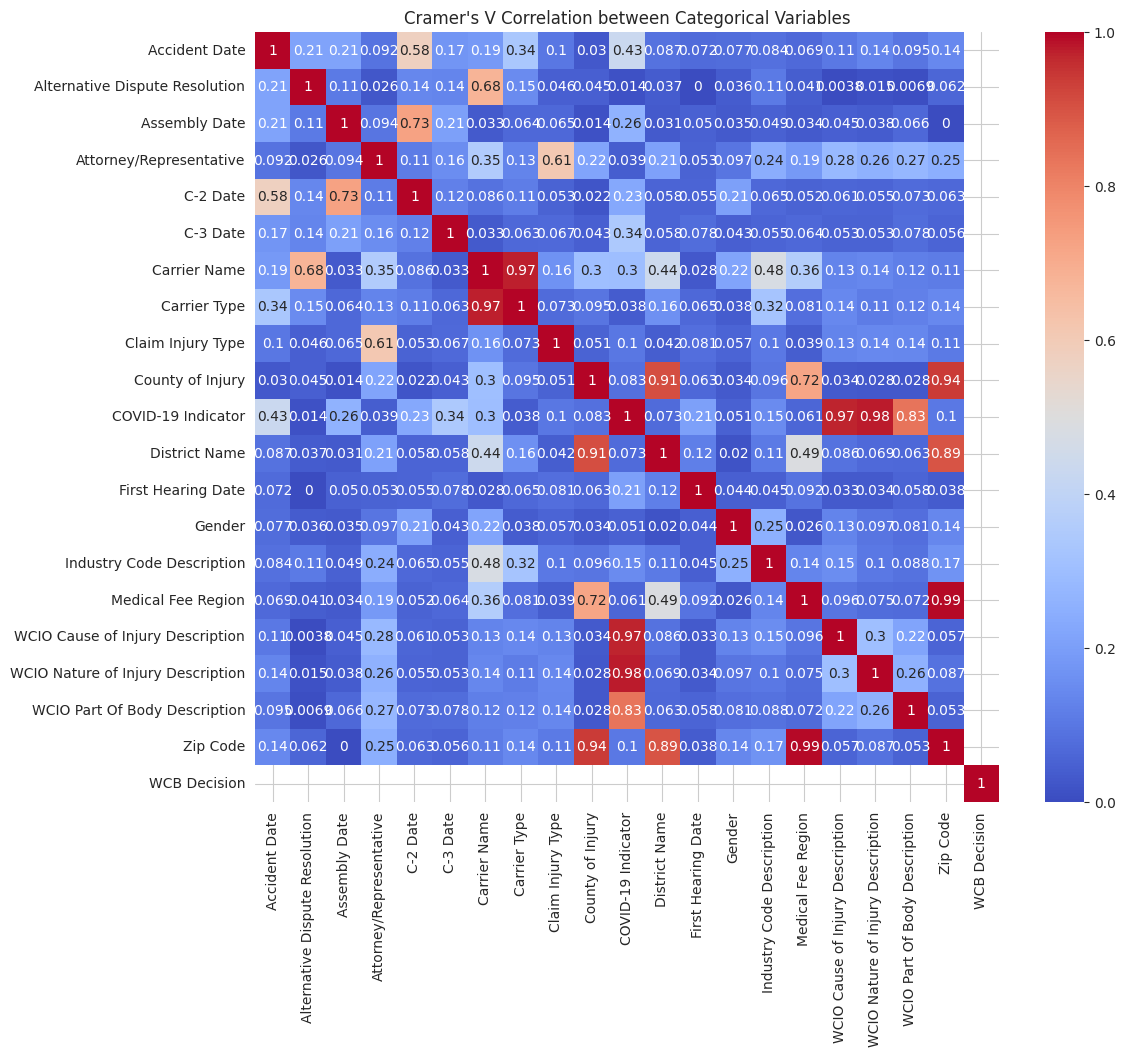

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Assuming your data is in a DataFrame called 'train_df'
categorical_columns = train_df.select_dtypes(include=['object']).columns.tolist()

# Function to compute Cramer's V between two categorical variables
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# Compute Cramer's V for each pair of categorical variables
cramer_matrix = np.zeros((len(categorical_columns), len(categorical_columns)))

for i in range(len(categorical_columns)):
    for j in range(len(categorical_columns)):
        if i == j:
            cramer_matrix[i][j] = 1.0
        else:
            cramer_matrix[i][j] = cramers_v(train_df[categorical_columns[i]], train_df[categorical_columns[j]])

# Convert to a DataFrame
cramer_df = pd.DataFrame(cramer_matrix, index=categorical_columns, columns=categorical_columns)

# Plot the heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(cramer_df, annot=True, cmap='coolwarm')
plt.title("Cramer's V Correlation between Categorical Variables")
plt.show()

In [90]:

# plt.figure(figsize=(14, 12))
# sns.heatmap(cramer_df, annot=True, cmap='coolwarm')
# plt.title("Cramer's V Correlation between Categorical Variables")
# plt.show()

cramer_df


,Accident Date,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Description,WCIO Nature of Injury Description,WCIO Part Of Body Description,Zip Code,WCB Decision
Accident Date,1.000000,0.211375,0.211279,0.092051,0.575968,0.173546,0.185219,0.335725,0.100652,0.029818,0.433168,0.087051,0.072156,0.077262,0.083699,0.069179,0.105267,0.135720,0.094630,0.144446,NaN
Alternative Dispute Resolution,0.211375,1.000000,0.107930,0.026448,0.137271,0.135559,0.678670,0.148724,0.046384,0.045209,0.014330,0.036552,0.000000,0.036138,0.107221,0.040785,0.003797,0.015005,0.006942,0.062043,NaN
Assembly Date,0.211279,0.107930,1.000000,0.093844,0.727407,0.206707,0.033053,0.064183,0.065147,0.014322,0.260253,0.031483,0.050003,0.034857,0.049241,0.033976,0.044547,0.038076,0.066004,0.000000,NaN
Attorney/Representative,0.092051,0.026448,0.093844,1.000000,0.110801,0.156050,0.354599,0.129083,0.611214,0.218384,0.039202,0.207061,0.052884,0.097361,0.242610,0.185906,0.282442,0.257392,0.274624,0.247847,NaN
C-2 Date,0.575968,0.137271,0.727407,0.110801,1.000000,0.124549,0.086161,0.113638,0.053059,0.021873,0.227088,0.057628,0.055109,0.205029,0.065392,0.052494,0.060657,0.055496,0.072613,0.062761,NaN
C-3 Date,0.173546,0.135559,0.206707,0.156050,0.124549,1.000000,0.033035,0.062861,0.067105,0.043001,0.340441,0.057821,0.077981,0.042987,0.054746,0.063873,0.052680,0.053167,0.078008,0.055671,NaN
Carrier Name,0.185219,0.678670,0.033053,0.354599,0.086161,0.033035,1.000000,0.973983,0.164534,0.303193,0.297065,0.439793,0.027780,0.218051,0.477511,0.362756,0.131433,0.139665,0.121039,0.110504,NaN
Carrier Type,0.335725,0.148724,0.064183,0.129083,0.113638,0.062861,0.973983,1.000000,0.073493,0.094912,0.038015,0.160343,0.064890,0.038187,0.321868,0.081126,0.142885,0.112849,0.121936,0.143362,NaN
Claim Injury Type,0.100652,0.046384,0.065147,0.611214,0.053059,0.067105,0.164534,0.073493,1.000000,0.051090,0.100187,0.042118,0.081004,0.056778,0.103374,0.039224,0.130462,0.142204,0.138520,0.109341,NaN
County of Injury,0.029818,0.045209,0.014322,0.218384,0.021873,0.043001,0.303193,0.094912,0.051090,1.000000,0.083184,0.909215,0.063089,0.033714,0.095861,0.722404,0.034291,0.028489,0.027737,0.938717,NaN


In [ ]:
train_df.to_csv("train_df.csv", index=False)

In [ ]:
# drop no accident date rows
#remove NaN


### Converting categorical variables to numerical
 We have to mind if they are nominal or ordinal

In [ ]:
# New to change zip to str to use freq

features_to_encode_freq = [
    "Alternative Dispute Resolution",  "Carrier Name",
    "County of Injury", "District Name", "Gender", "Medical Fee Region", "Zip Code"]

features_to_encode_binary = ["Attorney/Representative", "COVID-19 Indicator", "Carrier Type", "Claim Injury Type"]

#features_to_encode_ordinal = ["Carrier Type", "Claim Injury Type"]

features_to_metadata = [ "Claim Identifier",
    "OIICS Nature of Injury Description",
    "Industry Code Description", "WCIO Cause of Injury Description", "WCIO Cause of Injury Description",
    "WCIO Nature of Injury Description", "WCIO Part Of Body Description"
]

encoders_dict = {}

multiencoder(train_df, features_to_encode_freq, "frequency", encoders_dict)
multiencoder(train_df, features_to_encode_binary, "binary", encoders_dict)

#### Feature engineering and date to days/years

In [ ]:
features_to_dummy = ['First Hearing Date', 'C-2 Date', 'C-3 Date']
gen_dummy(train_df,features_to_dummy)

In [ ]:
features_to_days = ["Accident Date", "Assembly Date", "First Hearing Date", "Birth Year"]
date_to_number(train_df, features_to_days)

In [ ]:
features_to_drop = features_to_metadata + features_to_days + ["C-2 Date", "C-3 Date"]

for feature in features_to_drop:
    try:
        train_df = train_df.drop(feature, axis = 1)
    except:
        print(f"{feature} no longer in train_df")

In [ ]:
train_df.to_csv("./data/train_data_after_EDA.csv")